In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import geopandas as gpd
from shapely.geometry import Point, Polygon, LineString
import contextily as cx
import datetime as dt
import json
from joblib import Parallel, delayed

from functions_file import *
print(testfunction(4))

16


## Process data
First, reformat data from MSs and LDs for all polygons. Then gather and save the data in one file.

### 1. Reformat MS and LD data

**Key settings for reformatting**

In [2]:
polygons = pd.read_csv('../data/polygons11.csv')
polygons = polygons.drop([4])
polygons['polygon'] = polygons.name
poly_cols = ['polygon','lanes','direction','busstops','seplane','length','complexity','road_rank']

savefactors = {}
scalefactorsfile = 'scalefactors_bypolygon.pkl' # 'scalefactors_bypolygon_bymode.pkl'

# LD and MS data should have same resampling
resample = '30s' #30s
window = '3T' # 3min #3T
polygon_names = polygons.name.values

**Mobile sensor data**

In [6]:
#################
# Resample, scale and gather data for mobile sensor modes
#################
save = 'off'

for polygon_name in polygon_names:
    
    POLYGON = get_polygon(polygon_name,polygons)
    # 1. load 'regular' and 'car' data
    # 1.a. file 1 - regular
    nonresampled = import_sensor_data(POLYGON['name'],'MS')
    modes        = set(nonresampled['mode'])
    resampled    = sensor_resample_window(nonresampled,modes,resample=resample,window=window,POLYGON=POLYGON,plot='off',filna=False)
    display(nonresampled[nonresampled['mode']=='all'].head())
    display(resampled[resampled['mode']=='all'].head())
    # 1.b. file 2 - car penetration rates
    nonresampled_cars = import_sensor_data(POLYGON['name'],'MS',cars='Yes')
    modes_cars        = set(nonresampled_cars['mode'])
    resampled_cars    = sensor_resample_window(nonresampled_cars,modes_cars,resample=resample,window=window,POLYGON=POLYGON,plot='off',filna=False)
    # 1.c. combine data
    data = pd.concat([resampled,resampled_cars])
    
    # 2. normalize/scale by link
    cols       = ['densities','flows']
    xx         = data[data['mode']=='all'][cols]
    means      = xx.mean()
    data[cols] = data[cols]/xx.mean() 
    interval   = data[(data['mode']=='all')&(data.densities>0.2)&(data.densities<2)]
    slope      = interval.flows.mean()/interval.densities.mean()
    data.flows = data.flows/slope
    savefactors[polygon_name+'_MS'] = [1,slope,means[0],means[1]]
    
    # 3. reformat - create a df per mode, rename columns, merge
    result = []
    for mode in set(data['mode']):
        # can exclude exp_id - not needed & issues due to diff. experiment start/end times
        tmp = data[data['mode']==mode][['exp_id','polygon','DOW','times','speeds','densities','flows']]
        tmp = tmp.rename(columns={'speeds':'v_%s'%(mode),'densities':'k_%s'%(mode),'flows':'q_%s'%(mode)})
        if (len(result)<1):
            result = tmp
        else:
            result = pd.merge(result, tmp, on=['polygon','DOW','times','exp_id'],how='outer')
    
    # 4. add polygon information
    result = pd.merge(result, polygons[poly_cols], how='outer', on=['polygon'])
    display(result.head(2))
    
    # 5. save
    if save=='on':
        result.to_pickle('../output/data_processed/processed_data_MS_%s.pkl'%(POLYGON['name']))##change here
    print('Saved %s.'%(polygon_name))
    print('Length:',len(result))


106 106 106 106
85 85 85 85
114 114 114 114
99 99 99 99
107 107 107 107
87 87 87 87
118 118 118 118
102 102 102 102
84 84 84 84
68 68 68 68
73 73 73 73
76 76 76 76
104 104 104 104
74 74 74 74
90 90 90 90
90 90 90 90
87 87 87 87
74 74 74 74
83 83 83 83
80 80 80 80
107 107 107 107
85 85 85 85
115 115 115 115
100 100 100 100
106 106 106 106
86 86 86 86
116 116 116 116
101 101 101 101


,polygon,mode,day,DOW,exp_id,speeds,densities,flows,times
108,polygon_r0,all,"[1, 2, 3, 4, 5]",Wed,1,"[43.50565319197251, 46.906403772109286, 31.707...","[73.30049261083747, 66.25944170771758, 8.14449...","[3188.9858103278384, 3107.9921264567397, 258.2...","[[[2018-10-24 08:31:08, 2018-10-24 08:31:38, 2..."
109,polygon_r0,all,"[1, 2, 3, 4, 5]",Wed,2,"[46.592965772278106, 30.329708626263262, 39.57...","[36.06349206349206, 37.81818181818182, 49.2873...","[1680.3050513431087, 1147.0144353205017, 1950....","[[[2018-10-24 09:01:00, 2018-10-24 09:01:30, 2..."
110,polygon_r0,all,"[1, 2, 3, 4, 5]",Wed,3,"[6.3179556603263896, 11.962349213632573, 3.739...","[290.5747126436783, 330.45648604269286, 376.53...","[1835.8381504948416, 3953.03588595259, 1408.13...","[[[2018-10-24 09:31:00, 2018-10-24 09:31:30, 2..."
111,polygon_r0,all,"[1, 2, 3, 4, 5]",Wed,4,"[1.771167346906966, 1.5350982572303533, 10.671...","[303.1330049261085, 338.3382594417077, 320.157...","[536.8992800949119, 519.3824724233166, 3416.72...","[[[2018-10-24 10:01:31, 2018-10-24 10:02:01, 2..."
112,polygon_r0,all,"[1, 2, 3, 4, 5]",Wed,5,"[9.970273393632635, 4.602016259692032, 11.2474...","[180.38752052545155, 217.79967159277496, 237.2...","[1798.5128964382704, 1002.3176300255351, 2668....","[[[2018-10-24 10:31:00, 2018-10-24 10:31:30, 2..."


,polygon,mode,day,DOW,exp_id,speeds,densities,flows,times
982,polygon_r0,all,"[1, 2, 3, 4, 5]",Wed,1.0,43.505653,73.300493,3188.985810,2018-10-24 08:31:00
983,polygon_r0,all,"[1, 2, 3, 4, 5]",Wed,1.0,45.206028,69.779967,3148.488968,2018-10-24 08:31:30
984,polygon_r0,all,"[1, 2, 3, 4, 5]",Wed,1.0,40.706359,49.234811,2185.071911,2018-10-24 08:32:00
985,polygon_r0,all,"[1, 2, 3, 4, 5]",Wed,1.0,40.790123,46.344828,2025.361498,2018-10-24 08:32:30
986,polygon_r0,all,"[1, 2, 3, 4, 5]",Wed,1.0,42.063287,53.795731,2408.730332,2018-10-24 08:33:00


93 93 93 93
73 73 73 73
105 105 105 105
91 91 91 91


,exp_id,polygon,DOW,times,v_Taxi,k_Taxi,q_Taxi,v_all,k_all,q_all,...,v_Car,k_Car,q_Car,lanes,direction,busstops,seplane,length,complexity,road_rank
0,1.0,polygon_r0,Wed,2018-10-24 08:31:00,36.983537,0.112907,0.123718,43.505653,0.664457,0.856475,...,43.562997,0.286741,0.370092,3,170,0,1,0.105,1,0
1,1.0,polygon_r0,Wed,2018-10-24 08:31:30,42.355535,0.097893,0.120457,45.206028,0.632544,0.845599,...,44.307598,0.331638,0.436346,3,170,0,1,0.105,1,0


Saved polygon_r0.
Length: 1145
109 109 109 109
90 90 90 90
117 117 117 117
104 104 104 104
111 111 111 111
92 92 92 92
120 120 120 120
107 107 107 107
43 43 43 43
22 22 22 22
29 29 29 29
8 8 8 8
92 92 92 92
77 77 77 77
106 106 106 106
93 93 93 93
105 105 105 105
80 80 80 80
117 117 117 117
95 95 95 95
111 111 111 111
88 88 88 88
120 120 120 120
106 106 106 106
110 110 110 110
88 88 88 88
117 117 117 117
106 106 106 106


,polygon,mode,day,DOW,exp_id,speeds,densities,flows,times
107,polygon_r1,all,"[1, 2, 3, 4, 5]",Wed,1,"[30.31418773191111, 6.7955786200100405, 35.592...","[102.93596059113304, 20.65024630541872, 137.56...","[3120.420033724211, 140.33037229104477, 4896.1...","[[[2018-10-24 08:31:00, 2018-10-24 08:31:30, 2..."
108,polygon_r1,all,"[1, 2, 3, 4, 5]",Wed,2,"[33.57397000892104, 26.470290115576258, 24.152...","[139.29720853858788, 127.31691297208538, 129.5...","[4676.760301800969, 3370.115622990674, 3128.26...","[[[2018-10-24 09:01:04, 2018-10-24 09:01:34, 2..."
109,polygon_r1,all,"[1, 2, 3, 4, 5]",Wed,3,"[23.316800025075583, 14.632336206460359, 29.14...","[80.55172413793103, 41.983579638752055, 142.39...","[1878.2084433991918, 614.3178524249236, 4150.3...","[[[2018-10-24 09:31:00, 2018-10-24 09:31:30, 2..."
110,polygon_r1,all,"[1, 2, 3, 4, 5]",Wed,4,"[28.310315301995217, 19.772012359939964, 1.492...","[163.88834154351397, 167.1461412151067, 107.98...","[4639.730623417962, 3304.81557002136, 161.2040...","[[[2018-10-24 10:01:13, 2018-10-24 10:01:43, 2..."
111,polygon_r1,all,"[1, 2, 3, 4, 5]",Wed,5,"[38.76974443168936, 20.46594137846699, 8.61707...","[128.26272577996716, 54.75205254515598, 47.763...","[4972.713098601181, 1120.5522977399066, 411.58...","[[[2018-10-24 10:31:00, 2018-10-24 10:31:30, 2..."


,polygon,mode,day,DOW,exp_id,speeds,densities,flows,times
983,polygon_r1,all,"[1, 2, 3, 4, 5]",Wed,1.0,30.314188,102.935961,3120.420034,2018-10-24 08:31:00
984,polygon_r1,all,"[1, 2, 3, 4, 5]",Wed,1.0,18.554883,61.793103,1630.375203,2018-10-24 08:31:30
985,polygon_r1,all,"[1, 2, 3, 4, 5]",Wed,1.0,24.234014,87.049808,2718.979502,2018-10-24 08:32:00
986,polygon_r1,all,"[1, 2, 3, 4, 5]",Wed,1.0,27.385956,87.172414,2845.519143,2018-10-24 08:32:30
987,polygon_r1,all,"[1, 2, 3, 4, 5]",Wed,1.0,23.195330,74.120197,2304.605675,2018-10-24 08:33:00


89 89 89 89
78 78 78 78
107 107 107 107
86 86 86 86


,exp_id,polygon,DOW,times,v_Taxi,k_Taxi,q_Taxi,v_all,k_all,q_all,...,v_Car,k_Car,q_Car,lanes,direction,busstops,seplane,length,complexity,road_rank
0,1.0,polygon_r1,Wed,2018-10-24 08:31:00,30.398994,0.166231,0.226394,30.314188,0.946647,1.285662,...,28.260335,0.633661,0.802282,3,255,2,0,0.105,1,0
1,1.0,polygon_r1,Wed,2018-10-24 08:31:30,15.199497,0.128056,0.113197,18.554883,0.568278,0.671740,...,39.799553,0.372885,0.530070,3,255,2,0,0.105,1,0


Saved polygon_r1.
Length: 1239
107 107 107 107
85 85 85 85
107 107 107 107
72 72 72 72
111 111 111 111
92 92 92 92
120 120 120 120
103 103 103 103
83 83 83 83
49 49 49 49
87 87 87 87
27 27 27 27
96 96 96 96
80 80 80 80
111 111 111 111
87 87 87 87
62 62 62 62
32 32 32 32
77 77 77 77
46 46 46 46
106 106 106 106
88 88 88 88
114 114 114 114
99 99 99 99
111 111 111 111
92 92 92 92
118 118 118 118
103 103 103 103


,polygon,mode,day,DOW,exp_id,speeds,densities,flows,times
105,polygon_r2,all,"[1, 2, 3, 4, 5]",Wed,1,"[35.26761711323677, 1.9068327182897336, 0.4267...","[79.40886699507394, 49.129720853858785, 49.326...","[2800.561516578212, 93.68215916457936, 21.0485...","[[[2018-10-24 08:31:00, 2018-10-24 08:31:30, 2..."
106,polygon_r2,all,"[1, 2, 3, 4, 5]",Wed,2,"[0.0, 25.3468149850057, 25.03337728403157, 0.0...","[12.282430213464696, 82.88998357963877, 33.037...","[0.0, 2100.997077903264, 827.0468816990394, 0....","[[[2018-10-24 09:01:00, 2018-10-24 09:01:30, 2..."
107,polygon_r2,all,"[1, 2, 3, 4, 5]",Wed,3,"[15.067141226067028, 2.136228957263803, 0.0, 1...","[167.6190476190476, 171.7569786535304, 171.231...","[2525.539862655044, 366.9122314118125, 0.0, 26...","[[[2018-10-24 09:31:00, 2018-10-24 09:31:30, 2..."
108,polygon_r2,all,"[1, 2, 3, 4, 5]",Wed,4,"[11.503333666925933, 7.847585503992146, 1.0858...","[164.59770114942532, 155.40229885057468, 170.9...","[1893.4222771307975, 1219.5328277468252, 185.6...","[[[2018-10-24 10:01:00, 2018-10-24 10:01:30, 2..."
109,polygon_r2,all,"[1, 2, 3, 4, 5]",Wed,5,"[16.134212387692155, 2.98936496645465, 14.9754...","[43.87520525451559, 91.75697865353034, 84.2036...","[707.8918801299415, 274.29509741459077, 1260.9...","[[[2018-10-24 10:31:00, 2018-10-24 10:31:30, 2..."


,polygon,mode,day,DOW,exp_id,speeds,densities,flows,times
914,polygon_r2,all,"[1, 2, 3, 4, 5]",Wed,1.0,35.267617,79.408867,2800.561517,2018-10-24 08:31:00
915,polygon_r2,all,"[1, 2, 3, 4, 5]",Wed,1.0,18.587225,64.269294,1447.121838,2018-10-24 08:31:30
916,polygon_r2,all,"[1, 2, 3, 4, 5]",Wed,1.0,12.533722,59.288451,971.764092,2018-10-24 08:32:00
917,polygon_r2,all,"[1, 2, 3, 4, 5]",Wed,1.0,16.904056,68.883415,1461.703018,2018-10-24 08:32:30
918,polygon_r2,all,"[1, 2, 3, 4, 5]",Wed,1.0,14.123702,69.175698,1211.601493,2018-10-24 08:33:00


93 93 93 93
76 76 76 76
99 99 99 99
97 97 97 97


,exp_id,polygon,DOW,times,v_Taxi,k_Taxi,q_Taxi,v_all,k_all,q_all,...,v_Car,k_Car,q_Car,lanes,direction,busstops,seplane,length,complexity,road_rank
0,1.0,polygon_r2,Wed,2018-10-24 08:31:00,32.190337,0.161553,0.584815,35.267617,0.661484,2.623444,...,31.702120,0.362749,1.293216,2,35,0,0,0.084,1,0
1,1.0,polygon_r2,Wed,2018-10-24 08:31:30,32.190337,0.080777,0.292407,18.587225,0.535370,1.355601,...,16.033531,0.334845,0.652906,2,35,0,0,0.084,1,0


Saved polygon_r2.
Length: 1219
110 110 110 110
87 87 87 87
125 125 125 125
104 104 104 104
111 111 111 111
87 87 87 87
126 126 126 126
106 106 106 106
28 28 28 28
68 68 68 68
31 31 31 31
59 59 59 59
105 105 105 105
80 80 80 80
121 121 121 121
91 91 91 91
104 104 104 104
73 73 73 73
108 108 108 108
91 91 91 91
110 110 110 110
86 86 86 86
126 126 126 126
106 106 106 106
111 111 111 111
86 86 86 86
126 126 126 126
106 106 106 106


,polygon,mode,day,DOW,exp_id,speeds,densities,flows,times
107,polygon_r3,all,"[1, 2, 3, 4, 5]",Wed,1,"[21.166354934027943, 33.85429051104928, 34.732...","[18.206896551724142, 89.86973180076626, 120.27...","[385.3736346609227, 3042.4760085332246, 4177.4...","[[[2018-10-24 08:31:00, 2018-10-24 08:31:30, 2..."
108,polygon_r3,all,"[1, 2, 3, 4, 5]",Wed,2,"[31.57917843410941, 45.2028416499877, 39.89108...","[140.68965517241386, 42.87581699346405, 83.333...","[4442.863724522981, 1938.108766169407, 3324.25...","[[[2018-10-24 09:01:00, 2018-10-24 09:01:30, 2..."
109,polygon_r3,all,"[1, 2, 3, 4, 5]",Wed,3,"[10.639399897709785, 30.715334092731265, 40.51...","[53.63984674329503, 105.31800766283533, 72.582...","[570.6957799537817, 3234.8777913448184, 2940.4...","[[[2018-10-24 09:31:00, 2018-10-24 09:31:30, 2..."
110,polygon_r3,all,"[1, 2, 3, 4, 5]",Wed,4,"[13.858059456179275, 37.899076712874205, 37.73...","[84.59770114942528, 99.67816091954023, 35.1264...","[1172.3599723848213, 3777.7102672878746, 1325....","[[[2018-10-24 10:01:00, 2018-10-24 10:01:30, 2..."
111,polygon_r3,all,"[1, 2, 3, 4, 5]",Wed,5,"[24.69434469555608, 30.098893770492193, 11.689...","[172.75095785440612, 92.62835249042143, 99.739...","[4265.971699744186, 2788.0109417449007, 1165.9...","[[[2018-10-24 10:31:00, 2018-10-24 10:31:30, 2..."


,polygon,mode,day,DOW,exp_id,speeds,densities,flows,times
976,polygon_r3,all,"[1, 2, 3, 4, 5]",Wed,1.0,21.166355,18.206897,385.373635,2018-10-24 08:31:00
977,polygon_r3,all,"[1, 2, 3, 4, 5]",Wed,1.0,27.510323,54.038314,1713.924822,2018-10-24 08:31:30
978,polygon_r3,all,"[1, 2, 3, 4, 5]",Wed,1.0,29.917614,76.117497,2535.098125,2018-10-24 08:32:00
979,polygon_r3,all,"[1, 2, 3, 4, 5]",Wed,1.0,29.437175,58.559387,1942.512905,2018-10-24 08:32:30
980,polygon_r3,all,"[1, 2, 3, 4, 5]",Wed,1.0,31.307533,60.824521,2096.164132,2018-10-24 08:33:00


97 97 97 97
61 61 61 61
111 111 111 111
85 85 85 85


,exp_id,polygon,DOW,times,v_Taxi,k_Taxi,q_Taxi,v_all,k_all,q_all,...,v_Car,k_Car,q_Car,lanes,direction,busstops,seplane,length,complexity,road_rank
0,1.0,polygon_r3,Wed,2018-10-24 08:31:00,57.408052,0.183514,0.353520,21.166355,0.234930,0.166861,...,18.420514,0.134472,0.083120,3,310,0,1,0.09,1,0
1,1.0,polygon_r3,Wed,2018-10-24 08:31:30,44.315784,0.283613,0.377774,27.510323,0.697275,0.742105,...,26.378202,0.284368,0.291735,3,310,0,1,0.09,1,0


Saved polygon_r3.
Length: 1187
105 105 105 105
85 85 85 85
116 116 116 116
104 104 104 104
109 109 109 109
85 85 85 85
118 118 118 118
107 107 107 107
89 89 89 89
70 70 70 70
85 85 85 85
78 78 78 78
104 104 104 104
75 75 75 75
103 103 103 103
92 92 92 92
97 97 97 97
71 71 71 71
92 92 92 92
91 91 91 91
109 109 109 109
85 85 85 85
115 115 115 115
106 106 106 106
109 109 109 109
84 84 84 84
117 117 117 117
107 107 107 107


,polygon,mode,day,DOW,exp_id,speeds,densities,flows,times
108,polygon_r5,all,"[1, 2, 3, 4, 5]",Wed,1,"[26.623363735775445, 25.15460303778993, 30.788...","[28.101149425287346, 162.42758620689656, 95.03...","[748.1471225428021, 4085.801453420886, 2926.09...","[[[2018-10-24 08:31:00, 2018-10-24 08:31:30, 2..."
109,polygon_r5,all,"[1, 2, 3, 4, 5]",Wed,2,"[4.1720759927886455, 1.88648516387691, 1.04090...","[289.3977011494253, 239.22758620689655, 324.85...","[1207.3892013337404, 451.29929216939485, 338.1...","[[[2018-10-24 09:01:00, 2018-10-24 09:01:30, 2..."
110,polygon_r5,all,"[1, 2, 3, 4, 5]",Wed,3,"[8.98069489496842, 6.3810778633619645, 11.5285...","[142.41839080459772, 403.7885057471265, 294.47...","[1279.0161152484682, 2576.6058955029944, 3394....","[[[2018-10-24 09:31:00, 2018-10-24 09:31:30, 2..."
111,polygon_r5,all,"[1, 2, 3, 4, 5]",Wed,4,"[13.628520150257268, 2.7666901657417733, 5.152...","[254.5287356321841, 243.93563218390813, 412.02...","[3468.850002382726, 674.894314637221, 2123.102...","[[[2018-10-24 10:01:31, 2018-10-24 10:02:01, 2..."
112,polygon_r5,all,"[1, 2, 3, 4, 5]",Wed,5,"[14.163509047495488, 2.040505660450333, 5.4378...","[312.42298850574724, 172.3586206896552, 322.13...","[4425.00582434673, 351.69874114465335, 1751.72...","[[[2018-10-24 10:31:00, 2018-10-24 10:31:30, 2..."


,polygon,mode,day,DOW,exp_id,speeds,densities,flows,times
982,polygon_r5,all,"[1, 2, 3, 4, 5]",Wed,1.0,26.623364,28.101149,748.147123,2018-10-24 08:31:00
983,polygon_r5,all,"[1, 2, 3, 4, 5]",Wed,1.0,25.888983,95.264368,2416.974288,2018-10-24 08:31:30
984,polygon_r5,all,"[1, 2, 3, 4, 5]",Wed,1.0,27.521994,95.189579,2586.680520,2018-10-24 08:32:00
985,polygon_r5,all,"[1, 2, 3, 4, 5]",Wed,1.0,27.164347,74.394653,2018.349032,2018-10-24 08:32:30
986,polygon_r5,all,"[1, 2, 3, 4, 5]",Wed,1.0,29.594049,76.773653,2293.137757,2018-10-24 08:33:00


92 92 92 92
76 76 76 76
94 94 94 94
91 91 91 91


,exp_id,polygon,DOW,times,v_Taxi,k_Taxi,q_Taxi,v_all,k_all,q_all,...,v_Car,k_Car,q_Car,lanes,direction,busstops,seplane,length,complexity,road_rank
0,1.0,polygon_r5,Wed,2018-10-24 08:31:00,30.694082,0.101302,0.166408,26.623364,0.196433,0.279885,...,21.988285,0.094103,0.110738,3,170,0,1,0.075,1,0
1,1.0,polygon_r5,Wed,2018-10-24 08:31:30,30.207672,0.102452,0.165600,25.888983,0.665919,0.904199,...,21.094400,0.408293,0.445905,3,170,0,1,0.075,1,0


Saved polygon_r5.
Length: 1112
108 108 108 108
91 91 91 91
119 119 119 119
105 105 105 105
110 110 110 110
92 92 92 92
120 120 120 120
107 107 107 107
20 20 20 20
17 17 17 17
55 55 55 55
6 6 6 6
94 94 94 94
82 82 82 82
102 102 102 102
95 95 95 95
101 101 101 101
71 71 71 71
114 114 114 114
90 90 90 90
108 108 108 108
90 90 90 90
120 120 120 120
107 107 107 107
110 110 110 110
91 91 91 91
120 120 120 120
106 106 106 106


,polygon,mode,day,DOW,exp_id,speeds,densities,flows,times
104,polygon_r6,all,"[1, 2, 3, 4, 5]",Wed,1,"[9.371582810903615, 27.43909067553359, 39.7284...","[69.96961289470208, 90.68569163694012, 105.567...","[655.7260214895699, 2488.332915799478, 4194.02...","[[[2018-10-24 08:31:00, 2018-10-24 08:31:30, 2..."
105,polygon_r6,all,"[1, 2, 3, 4, 5]",Wed,2,"[41.44235276794614, 39.016760756412765, 37.560...","[94.7866296736689, 99.26806711586731, 54.29666...","[3928.180944620858, 3873.1184254113205, 2039.4...","[[[2018-10-24 09:01:00, 2018-10-24 09:01:30, 2..."
106,polygon_r6,all,"[1, 2, 3, 4, 5]",Wed,3,"[9.837804167785917, 20.870323455331828, 26.179...","[92.08085612366231, 139.89694807768524, 121.21...","[905.8734301466606, 2919.694556795053, 3173.28...","[[[2018-10-24 09:31:00, 2018-10-24 09:31:30, 2..."
107,polygon_r6,all,"[1, 2, 3, 4, 5]",Wed,4,"[31.438678611305075, 6.577668188473406, 32.535...","[78.46743295019161, 136.3456202933016, 141.630...","[2466.912405975204, 896.8362492409241, 4607.94...","[[[2018-10-24 10:01:31, 2018-10-24 10:02:01, 2..."
108,polygon_r6,all,"[1, 2, 3, 4, 5]",Wed,5,"[39.10893613269245, 4.089701773902375, 20.7246...","[59.696128947020746, 108.78055225260931, 153.6...","[2334.652094358007, 444.8800175135763, 3184.95...","[[[2018-10-24 10:31:00, 2018-10-24 10:31:30, 2..."


,polygon,mode,day,DOW,exp_id,speeds,densities,flows,times
984,polygon_r6,all,"[1, 2, 3, 4, 5]",Wed,1.0,9.371583,69.969613,655.726021,2018-10-24 08:31:00
985,polygon_r6,all,"[1, 2, 3, 4, 5]",Wed,1.0,18.405337,80.327652,1572.029469,2018-10-24 08:31:30
986,polygon_r6,all,"[1, 2, 3, 4, 5]",Wed,1.0,25.513036,88.740917,2446.029470,2018-10-24 08:32:00
987,polygon_r6,all,"[1, 2, 3, 4, 5]",Wed,1.0,20.592169,80.539041,1916.039003,2018-10-24 08:32:30
988,polygon_r6,all,"[1, 2, 3, 4, 5]",Wed,1.0,20.073443,92.917955,2045.550545,2018-10-24 08:33:00


80 80 80 80
70 70 70 70
102 102 102 102
91 91 91 91


,exp_id,polygon,DOW,times,v_Taxi,k_Taxi,q_Taxi,v_all,k_all,q_all,...,v_Car,k_Car,q_Car,lanes,direction,busstops,seplane,length,complexity,road_rank
0,1.0,polygon_r6,Wed,2018-10-24 08:31:00,9.303682,0.074535,0.035079,9.371583,0.663202,0.314403,...,10.255531,0.504114,0.261526,3,260,0,1,0.1305,1,0
1,1.0,polygon_r6,Wed,2018-10-24 08:31:30,20.112293,0.078743,0.082413,18.405337,0.761381,0.753746,...,14.985662,0.485080,0.363165,3,260,0,1,0.1305,1,0


Saved polygon_r6.
Length: 1222
92 92 92 92
84 84 84 84
109 109 109 109
95 95 95 95
100 100 100 100
91 91 91 91
117 117 117 117
104 104 104 104
47 47 47 47
22 22 22 22
78 78 78 78
8 8 8 8
40 40 40 40
49 49 49 49
88 88 88 88
72 72 72 72
43 43 43 43
18 18 18 18
25 25 25 25
29 29 29 29
94 94 94 94
81 81 81 81
108 108 108 108
100 100 100 100
99 99 99 99
89 89 89 89
116 116 116 116
103 103 103 103


,polygon,mode,day,DOW,exp_id,speeds,densities,flows,times
99,polygon_r7,all,"[1, 2, 3, 4, 5]",Wed,1,"[26.194116525892685, 36.5456379070353, 2.48892...","[17.829401088929217, 13.531760435571679, 14.63...","[467.0254097102898, 494.5268171231489, 36.4259...","[[[2018-10-24 08:31:19, 2018-10-24 08:31:49, 2..."
100,polygon_r7,all,"[1, 2, 3, 4, 5]",Wed,2,"[19.70984390676599, 0.0172469482783313, 7.7770...","[44.60254083484575, 43.32486388384754, 45.0090...","[879.1091176999656, 0.7472216865704623, 350.03...","[[[2018-10-24 09:01:00, 2018-10-24 09:01:30, 2..."
101,polygon_r7,all,"[1, 2, 3, 4, 5]",Wed,3,"[14.853265753647277, 30.10084608655586, 9.4813...","[30.373865698729585, 9.23411978221415, 64.6969...","[451.15109918882183, 277.9548183092488, 613.41...","[[[2018-10-24 09:31:16, 2018-10-24 09:31:46, 2..."
102,polygon_r7,all,"[1, 2, 3, 4, 5]",Wed,4,"[4.717770985332279, 7.620921868047263, 8.73260...","[43.38294010889292, 54.53357531760436, 50.8747...","[204.67077610414296, 415.59611668073353, 444.2...","[[[2018-10-24 10:01:00, 2018-10-24 10:01:30, 2..."
103,polygon_r7,all,"[1, 2, 3, 4, 5]",Wed,5,"[13.33096600238011, 11.876398030336944, 0.7657...","[28.98003629764065, 27.586206896551733, 32.638...","[386.33187863158906, 327.6247732506744, 24.992...","[[[2018-10-24 10:31:09, 2018-10-24 10:31:39, 2..."


,polygon,mode,day,DOW,exp_id,speeds,densities,flows,times
971,polygon_r7,all,"[1, 2, 3, 4, 5]",Wed,1.0,26.194117,17.829401,467.025410,2018-10-24 08:31:00
972,polygon_r7,all,"[1, 2, 3, 4, 5]",Wed,1.0,31.369877,15.680581,480.776113,2018-10-24 08:31:30
973,polygon_r7,all,"[1, 2, 3, 4, 5]",Wed,1.0,21.742894,15.332123,332.659408,2018-10-24 08:32:00
974,polygon_r7,all,"[1, 2, 3, 4, 5]",Wed,1.0,22.123618,18.903811,421.771176,2018-10-24 08:32:30
975,polygon_r7,all,"[1, 2, 3, 4, 5]",Wed,1.0,23.041650,21.302359,502.489650,2018-10-24 08:33:00


45 45 45 45
40 40 40 40
70 70 70 70
59 59 59 59


,exp_id,polygon,DOW,times,v_Taxi,k_Taxi,q_Taxi,v_all,k_all,q_all,...,v_Car,k_Car,q_Car,lanes,direction,busstops,seplane,length,complexity,road_rank
0,1.0,polygon_r7,Wed,2018-10-24 08:31:30,31.414802,0.188195,0.764282,31.369877,0.262825,1.041735,...,27.289035,0.191765,0.677813,2,220,0,0,0.095,1,0
1,1.0,polygon_r7,Wed,2018-10-24 08:32:00,31.414802,0.094098,0.382141,21.742894,0.256984,0.720799,...,18.682386,0.206366,0.466788,2,220,0,0,0.095,1,0


Saved polygon_r7.
Length: 1288
110 110 110 110
86 86 86 86
126 126 126 126
97 97 97 97
111 111 111 111
87 87 87 87
126 126 126 126
99 99 99 99
68 68 68 68
66 66 66 66
75 75 75 75
62 62 62 62
101 101 101 101
82 82 82 82
123 123 123 123
87 87 87 87
104 104 104 104
74 74 74 74
117 117 117 117
84 84 84 84
110 110 110 110
87 87 87 87
125 125 125 125
99 99 99 99
111 111 111 111
87 87 87 87
126 126 126 126
99 99 99 99


,polygon,mode,day,DOW,exp_id,speeds,densities,flows,times
107,polygon_r8,all,"[1, 2, 3, 4, 5]",Wed,1,"[27.062181717599692, 29.624745404689158, 35.69...","[52.169358358795286, 121.30947184635527, 65.43...","[1411.8166559962965, 3593.7622186255817, 2335....","[[[2018-10-24 08:31:00, 2018-10-24 08:31:30, 2..."
108,polygon_r8,all,"[1, 2, 3, 4, 5]",Wed,2,"[37.5853098530538, 25.12113650378494, 24.43083...","[99.93889131383673, 69.48930597992143, 103.710...","[3756.2341964012207, 1745.650341074885, 2533.7...","[[[2018-10-24 09:01:00, 2018-10-24 09:01:30, 2..."
109,polygon_r8,all,"[1, 2, 3, 4, 5]",Wed,3,"[16.383146767122494, 30.1668616421722, 29.3616...","[96.09777389786117, 96.16761239633347, 133.810...","[1574.3839337624127, 2901.075057618236, 3928.9...","[[[2018-10-24 09:31:00, 2018-10-24 09:31:30, 2..."
110,polygon_r8,all,"[1, 2, 3, 4, 5]",Wed,4,"[23.651664625003313, 33.7940522548422, 26.3980...","[108.04015713662156, 108.94805761676119, 75.49...","[2555.3295626280315, 3681.796352164386, 1992.9...","[[[2018-10-24 10:01:00, 2018-10-24 10:01:30, 2..."
111,polygon_r8,all,"[1, 2, 3, 4, 5]",Wed,5,"[34.27227666813173, 34.3669307940719, 23.81163...","[115.93190746398953, 82.96813618507196, 88.625...","[3973.2504072700954, 2851.3601943855006, 2110....","[[[2018-10-24 10:31:00, 2018-10-24 10:31:30, 2..."


,polygon,mode,day,DOW,exp_id,speeds,densities,flows,times
974,polygon_r8,all,"[1, 2, 3, 4, 5]",Wed,1.0,27.062182,52.169358,1411.816656,2018-10-24 08:31:00
975,polygon_r8,all,"[1, 2, 3, 4, 5]",Wed,1.0,28.343464,86.739415,2502.789437,2018-10-24 08:31:30
976,polygon_r8,all,"[1, 2, 3, 4, 5]",Wed,1.0,30.793832,79.639168,2447.128008,2018-10-24 08:32:00
977,polygon_r8,all,"[1, 2, 3, 4, 5]",Wed,1.0,30.570009,69.821039,2137.072022,2018-10-24 08:32:30
978,polygon_r8,all,"[1, 2, 3, 4, 5]",Wed,1.0,31.251417,75.467481,2375.969629,2018-10-24 08:33:00


89 89 89 89
74 74 74 74
109 109 109 109
85 85 85 85


,exp_id,polygon,DOW,times,v_Taxi,k_Taxi,q_Taxi,v_all,k_all,q_all,...,v_Car,k_Car,q_Car,lanes,direction,busstops,seplane,length,complexity,road_rank
0,1.0,polygon_r8,Wed,2018-10-24 08:31:00,30.289225,0.165394,0.176769,27.062182,0.591144,0.564488,...,25.528657,0.387765,0.349297,3,310,1,0,0.079,1,0
1,1.0,polygon_r8,Wed,2018-10-24 08:31:30,29.597930,0.136509,0.143272,28.343464,0.982865,1.000692,...,24.029339,0.541684,0.451146,3,310,1,0,0.079,1,0


Saved polygon_r8.
Length: 1105
106 106 106 106
89 89 89 89
116 116 116 116
99 99 99 99
110 110 110 110
91 91 91 91
120 120 120 120
106 106 106 106
57 57 57 57
40 40 40 40
80 80 80 80
49 49 49 49
93 93 93 93
71 71 71 71
107 107 107 107
78 78 78 78
65 65 65 65
55 55 55 55
88 88 88 88
83 83 83 83
110 110 110 110
87 87 87 87
117 117 117 117
104 104 104 104
109 109 109 109
91 91 91 91
120 120 120 120
106 106 106 106


,polygon,mode,day,DOW,exp_id,speeds,densities,flows,times
106,polygon_r9,all,"[1, 2, 3, 4, 5]",Wed,1,"[11.6296830956253, 5.279371807776968, 4.545205...","[141.25324434556913, 74.98702261772335, 122.98...","[1642.7304679678953, 395.88437315714253, 558.9...","[[[2018-10-24 08:31:00, 2018-10-24 08:31:30, 2..."
107,polygon_r9,all,"[1, 2, 3, 4, 5]",Wed,2,"[1.6033052103285401, 0.7367993327583358, 0.356...","[249.87764182424922, 275.09084167593613, 288.0...","[400.63012508142754, 202.68674859475874, 102.6...","[[[2018-10-24 09:01:00, 2018-10-24 09:01:30, 2..."
108,polygon_r9,all,"[1, 2, 3, 4, 5]",Wed,3,"[11.236344575669522, 5.772229083211118, 1.2372...","[93.37782721542455, 112.8958101594364, 182.068...","[1049.2254423198415, 651.66047877498, 225.2616...","[[[2018-10-24 09:31:00, 2018-10-24 09:31:30, 2..."
109,polygon_r9,all,"[1, 2, 3, 4, 5]",Wed,4,"[10.201371586704251, 24.845297256586434, 15.42...","[98.12384130515387, 78.79569892473114, 60.2150...","[1000.9977666686738, 1957.7025623254333, 928.7...","[[[2018-10-24 10:01:31, 2018-10-24 10:02:01, 2..."
110,polygon_r9,all,"[1, 2, 3, 4, 5]",Wed,5,"[3.6226689784558044, 12.253811144436412, 5.771...","[109.15832406377457, 86.61475713756026, 99.310...","[395.4444743260619, 1061.3608762848892, 573.16...","[[[2018-10-24 10:31:00, 2018-10-24 10:31:30, 2..."


,polygon,mode,day,DOW,exp_id,speeds,densities,flows,times
980,polygon_r9,all,"[1, 2, 3, 4, 5]",Wed,1.0,11.629683,141.253244,1642.730468,2018-10-24 08:31:00
981,polygon_r9,all,"[1, 2, 3, 4, 5]",Wed,1.0,8.454527,108.120133,1019.307421,2018-10-24 08:31:30
982,polygon_r9,all,"[1, 2, 3, 4, 5]",Wed,1.0,7.151420,113.073786,865.863056,2018-10-24 08:32:00
983,polygon_r9,all,"[1, 2, 3, 4, 5]",Wed,1.0,9.196529,111.308862,1055.745437,2018-10-24 08:32:30
984,polygon_r9,all,"[1, 2, 3, 4, 5]",Wed,1.0,8.848847,102.407119,944.237042,2018-10-24 08:33:00


71 71 71 71
51 51 51 51
86 86 86 86
67 67 67 67


,exp_id,polygon,DOW,times,v_Taxi,k_Taxi,q_Taxi,v_all,k_all,q_all,...,v_Car,k_Car,q_Car,lanes,direction,busstops,seplane,length,complexity,road_rank
0,1.0,polygon_r9,Wed,2018-10-24 08:31:00,14.565058,0.259703,0.463041,11.629683,1.341330,1.909560,...,9.112071,0.855162,0.953883,2,350,1,0,0.093,1,1
1,1.0,polygon_r9,Wed,2018-10-24 08:31:30,8.293328,0.229282,0.256127,8.454527,1.026701,1.184874,...,7.278094,0.612640,0.600271,2,350,1,0,0.093,1,1


Saved polygon_r9.
Length: 1230
103 103 103 103
89 89 89 89
116 116 116 116
106 106 106 106
110 110 110 110
92 92 92 92
120 120 120 120
107 107 107 107
83 83 83 83
74 74 74 74
108 108 108 108
72 72 72 72
97 97 97 97
73 73 73 73
114 114 114 114
96 96 96 96
28 28 28 28
30 30 30 30
37 37 37 37
43 43 43 43
108 108 108 108
88 88 88 88
113 113 113 113
105 105 105 105
109 109 109 109
92 92 92 92
119 119 119 119
106 106 106 106


,polygon,mode,day,DOW,exp_id,speeds,densities,flows,times
106,polygon_r10,all,"[1, 2, 3, 4, 5]",Wed,1,"[3.6044292882386215, 4.2287459058672345, 6.083...","[192.38380809595205, 212.95352323838088, 219.3...","[693.433832483928, 900.5263395343061, 1334.563...","[[[2018-10-24 08:31:00, 2018-10-24 08:31:30, 2..."
107,polygon_r10,all,"[1, 2, 3, 4, 5]",Wed,2,"[10.373291160144362, 6.326879895180462, nan, 2...","[8.695652173913043, 28.11594202898551, 0, 49.0...","[90.20253182734227, 177.8861883572478, 0, 1235...","[[[2018-10-24 09:01:00, 2018-10-24 09:01:30, 2..."
108,polygon_r10,all,"[1, 2, 3, 4, 5]",Wed,3,"[16.071096992570393, 4.2594695434416545, 13.85...","[115.86206896551725, 149.44527736131934, 67.94...","[1862.0305481047076, 636.5576073317303, 941.41...","[[[2018-10-24 09:31:00, 2018-10-24 09:31:30, 2..."
109,polygon_r10,all,"[1, 2, 3, 4, 5]",Wed,4,"[10.972619320853767, 10.814901815517047, 4.221...","[100.44977511244377, 145.06746626686663, 140.4...","[1102.1971431742163, 1568.8904043019938, 592.9...","[[[2018-10-24 10:01:31, 2018-10-24 10:02:01, 2..."
110,polygon_r10,all,"[1, 2, 3, 4, 5]",Wed,5,"[10.712346501930394, 9.83927685331664, 3.42561...","[82.15892053973013, 123.71814092953521, 88.755...","[880.1148250461553, 1217.297040383342, 304.042...","[[[2018-10-24 10:31:00, 2018-10-24 10:31:30, 2..."


,polygon,mode,day,DOW,exp_id,speeds,densities,flows,times
982,polygon_r10,all,"[1, 2, 3, 4, 5]",Wed,1.0,3.604429,192.383808,693.433832,2018-10-24 08:31:00
983,polygon_r10,all,"[1, 2, 3, 4, 5]",Wed,1.0,3.916588,202.668666,796.980086,2018-10-24 08:31:30
984,polygon_r10,all,"[1, 2, 3, 4, 5]",Wed,1.0,4.638929,208.235882,976.174684,2018-10-24 08:32:00
985,polygon_r10,all,"[1, 2, 3, 4, 5]",Wed,1.0,4.955309,235.502249,1200.503536,2018-10-24 08:32:30
986,polygon_r10,all,"[1, 2, 3, 4, 5]",Wed,1.0,4.670016,239.916042,1142.188586,2018-10-24 08:33:00


87 87 87 87
73 73 73 73
89 89 89 89
91 91 91 91


,exp_id,polygon,DOW,times,v_Taxi,k_Taxi,q_Taxi,v_all,k_all,q_all,...,v_Car,k_Car,q_Car,lanes,direction,busstops,seplane,length,complexity,road_rank
0,1.0,polygon_r10,Wed,2018-10-24 08:31:30,3.363123,0.120179,0.052484,3.916588,1.431167,0.730821,...,3.905937,1.250974,0.635074,2,170,1,0,0.092,1,1
1,1.0,polygon_r10,Wed,2018-10-24 08:32:00,3.742078,0.150504,0.074626,4.638929,1.470481,0.895140,...,4.507579,1.194086,0.690430,2,170,1,0,0.092,1,1


Saved polygon_r10.
Length: 1232
111 111 111 111
87 87 87 87
126 126 126 126
106 106 106 106
111 111 111 111
87 87 87 87
126 126 126 126
106 106 106 106
70 70 70 70
38 38 38 38
18 18 18 18
78 78 78 78
103 103 103 103
84 84 84 84
119 119 119 119
79 79 79 79
107 107 107 107
86 86 86 86
125 125 125 125
102 102 102 102
109 109 109 109
86 86 86 86
125 125 125 125
106 106 106 106
110 110 110 110
87 87 87 87
125 125 125 125
106 106 106 106


,polygon,mode,day,DOW,exp_id,speeds,densities,flows,times
108,polygon_r11,all,"[1, 2, 3, 4, 5]",Wed,1,"[6.280240330635675, 39.00346210090852, 36.5690...","[38.210316329438584, 125.84781989170705, 109.5...","[239.96996965848712, 4908.5006736281575, 4006....","[[[2018-10-24 08:31:00, 2018-10-24 08:31:30, 2..."
109,polygon_r11,all,"[1, 2, 3, 4, 5]",Wed,2,"[29.21670493769032, 10.423075133858273, 15.835...","[180.92903961242527, 159.8632088914221, 158.08...","[5286.150365015913, 1666.2662374149722, 2503.3...","[[[2018-10-24 09:01:00, 2018-10-24 09:01:30, 2..."
110,polygon_r11,all,"[1, 2, 3, 4, 5]",Wed,3,"[7.657960129467233, 31.207545564113385, 26.239...","[35.97606155599886, 145.45454545454544, 131.82...","[275.50324501109816, 4539.279354780128, 3458.8...","[[[2018-10-24 09:31:00, 2018-10-24 09:31:30, 2..."
111,polygon_r11,all,"[1, 2, 3, 4, 5]",Wed,4,"[20.606211775541464, 41.042845977430204, 34.61...","[34.06098603590766, 99.26474779139355, 57.5890...","[701.8678915396738, 4074.10775459062, 1993.653...","[[[2018-10-24 10:01:00, 2018-10-24 10:01:30, 2..."
112,polygon_r11,all,"[1, 2, 3, 4, 5]",Wed,5,"[44.89265764661183, 29.882740653684785, 6.8146...","[90.41892277001995, 103.00370475919065, 98.261...","[4059.1457446899403, 3078.0329956876117, 669.6...","[[[2018-10-24 10:31:00, 2018-10-24 10:31:30, 2..."


,polygon,mode,day,DOW,exp_id,speeds,densities,flows,times
976,polygon_r11,all,"[1, 2, 3, 4, 5]",Wed,1.0,6.280240,38.210316,239.969970,2018-10-24 08:31:00
977,polygon_r11,all,"[1, 2, 3, 4, 5]",Wed,1.0,22.641851,82.029068,2574.235322,2018-10-24 08:31:30
978,polygon_r11,all,"[1, 2, 3, 4, 5]",Wed,1.0,27.284250,91.209271,3051.776452,2018-10-24 08:32:00
979,polygon_r11,all,"[1, 2, 3, 4, 5]",Wed,1.0,22.123892,86.645768,2409.989442,2018-10-24 08:32:30
980,polygon_r11,all,"[1, 2, 3, 4, 5]",Wed,1.0,24.807038,96.136791,2881.170592,2018-10-24 08:33:00


86 86 86 86
75 75 75 75
108 108 108 108
100 100 100 100


,exp_id,polygon,DOW,times,v_Taxi,k_Taxi,q_Taxi,v_all,k_all,q_all,...,v_Car,k_Car,q_Car,lanes,direction,busstops,seplane,length,complexity,road_rank
0,1.0,polygon_r11,Wed,2018-10-24 08:31:00,3.836559,0.06952,0.011255,6.280240,0.311538,0.082559,...,5.455707,0.151308,0.034833,4,130,1,0,0.121,1,0
1,1.0,polygon_r11,Wed,2018-10-24 08:31:30,19.947146,0.12231,0.138836,22.641851,0.668804,0.885636,...,24.270114,0.283656,0.395567,4,130,1,0,0.121,1,0


Saved polygon_r11.
Length: 1192


In [111]:
polygon_name = polygon_names[0]
POLYGON = get_polygon(polygon_name,polygons)
nonresampled = import_sensor_data(POLYGON['name'],'MS')
#mode = 'Car'
#moede_sel = nonresampled[nonresampled['mode']==mode]
#exp_sec = moede_sel[moede_sel['exp_id']==1]
nonresampled.head(25)['times']

0     [[[2018-10-24 08:31:13, 2018-10-24 08:31:43, 2...
1     [[[2018-10-24 09:01:00, 2018-10-24 09:01:30, 2...
2     [[[2018-10-24 09:31:00, 2018-10-24 09:31:30, 2...
3     [[[2018-10-24 10:01:31, 2018-10-24 10:02:01, 2...
4     [[[2018-10-24 10:31:00, 2018-10-24 10:31:30, 2...
5     [[[2018-10-25 08:01:05, 2018-10-25 08:01:35, 2...
6     [[[2018-10-25 08:31:00, 2018-10-25 08:31:30, 2...
7     [[[2018-10-25 09:31:00, 2018-10-25 09:31:30, 2...
8     [[[2018-10-25 10:01:04, 2018-10-25 10:01:34, 2...
9     [[[2018-10-30 08:01:10, 2018-10-30 08:01:40, 2...
10    [[[2018-10-30 08:31:00, 2018-10-30 08:31:30, 2...
11    [[[2018-10-30 09:04:48, 2018-10-30 09:05:18, 2...
12    [[[2018-10-30 09:31:39, 2018-10-30 09:32:09, 2...
13    [[[2018-10-30 10:01:00, 2018-10-30 10:01:30, 2...
14    [[[2018-11-01 08:31:00, 2018-11-01 08:31:30, 2...
15    [[[2018-11-01 09:01:29, 2018-11-01 09:01:59, 2...
16    [[[2018-11-01 09:31:29, 2018-11-01 09:31:59, 2...
17    [[[2018-11-01 10:01:03, 2018-11-01 10:01:3

**Loop detector data**

In [7]:
#################
# Resampe, scale and gather data for 'all' using loop detector approach
#################
save = 'off'

for polygon_name in polygon_names:
    
    POLYGON = get_polygon(polygon_name,polygons)
    # 1. load 'all' from 'regular' data
    nonresampled = import_sensor_data(POLYGON['name'],sensor='LD')
    modes        = set(nonresampled['mode'])
    resampled    = sensor_resample_window(nonresampled,modes,resample=resample,window=window,POLYGON=POLYGON,plot='off')
    data         = resampled
    
    # 2. normalize/scale by link
    xx = data[data['mode']=='all'][['densities','flows']]
    means    = xx.mean()
    data[['densities','flows']] = data[['densities','flows']]/xx.mean() # dont need exp_id or speeds
    interval = data[(data['mode']=='all')&(data.densities>0.2)&(data.densities<2)]
    slope    = interval.flows.mean()/interval.densities.mean()
    savefactors[polygon_name+'_LD'] = [1,slope,means[0],means[1]]
    
    # 3. reformat - create a df per mode, rename columns, merge
    result = []
    for mode in set(data['mode']):
        tmp = data[data['mode']==mode][['exp_id','polygon','DOW','times','speeds','densities','flows']]
        tmp = tmp.rename(columns={'speeds':'v_%s'%(mode),'densities':'k_%s'%(mode),'flows':'q_%s'%(mode)})
        if (len(result)<1):
            result = tmp
        else:
            result = pd.merge(result, tmp, on=['polygon','DOW','times','exp_id'],how='outer')
    
    # 4. add polygon information
    result = pd.merge(result, polygons[poly_cols], how='outer', on=['polygon'])
    display(result.head(2))
    
    # 5. save
    if save=='on':
        result.to_pickle('../output/data_processed/processed_data_LD_%s.pkl'%(POLYGON['name'])) # index=False#with parked
    print('Saved.')
    print('Length:',len(result))

print(savefactors)

100 100 100 100
83 83 83 83
114 114 114 114
99 99 99 99


,exp_id,polygon,DOW,times,v_all,k_all,q_all,lanes,direction,busstops,seplane,length,complexity,road_rank
0,1.0,polygon_r0,Wed,2018-10-24 08:31:00,41.994024,1.282766,2.037116,3,170,0,1,0.105,1,0
1,1.0,polygon_r0,Wed,2018-10-24 08:31:30,46.472627,1.849675,3.346691,3,170,0,1,0.105,1,0


Saved.
Length: 988
105 105 105 105
87 87 87 87
114 114 114 114
100 100 100 100


,exp_id,polygon,DOW,times,v_all,k_all,q_all,lanes,direction,busstops,seplane,length,complexity,road_rank
0,1.0,polygon_r1,Wed,2018-10-24 08:31:00,31.320353,2.976523,3.454123,3,255,2,0,0.105,1,0
1,1.0,polygon_r1,Wed,2018-10-24 08:31:30,24.976925,1.571647,1.784630,3,255,2,0,0.105,1,0


Saved.
Length: 990
101 101 101 101
84 84 84 84
108 108 108 108
97 97 97 97


,exp_id,polygon,DOW,times,v_all,k_all,q_all,lanes,direction,busstops,seplane,length,complexity,road_rank
0,1.0,polygon_r2,Wed,2018-10-24 08:31:00,35.771697,4.216295,6.343412,2,35,0,0,0.084,1,0
1,1.0,polygon_r2,Wed,2018-10-24 08:31:30,32.042443,2.219127,3.303860,2,35,0,0,0.084,1,0


Saved.
Length: 985
106 106 106 106
83 83 83 83
121 121 121 121
102 102 102 102


,exp_id,polygon,DOW,times,v_all,k_all,q_all,lanes,direction,busstops,seplane,length,complexity,road_rank
0,1.0,polygon_r3,Wed,2018-10-24 08:31:00,35.228147,0.481705,0.454245,3,310,0,1,0.09,1,0
1,1.0,polygon_r3,Wed,2018-10-24 08:31:30,36.205000,1.667083,1.646640,3,310,0,1,0.09,1,0


Saved.
Length: 982
103 103 103 103
83 83 83 83
114 114 114 114
103 103 103 103


,exp_id,polygon,DOW,times,v_all,k_all,q_all,lanes,direction,busstops,seplane,length,complexity,road_rank
0,1.0,polygon_r5,Wed,2018-10-24 08:31:00,38.776348,0.617987,1.052356,3,170,0,1,0.075,1,0
1,1.0,polygon_r5,Wed,2018-10-24 08:31:30,34.487228,2.044852,2.828206,3,170,0,1,0.075,1,0


Saved.
Length: 989
103 103 103 103
86 86 86 86
115 115 115 115
101 101 101 101


,exp_id,polygon,DOW,times,v_all,k_all,q_all,lanes,direction,busstops,seplane,length,complexity,road_rank
0,1.0,polygon_r6,Wed,2018-10-24 08:31:00,18.065748,1.459366,1.016218,3,260,0,1,0.1305,1,0
1,1.0,polygon_r6,Wed,2018-10-24 08:31:30,24.318044,1.699908,1.651355,3,260,0,1,0.1305,1,0


Saved.
Length: 988
96 96 96 96
88 88 88 88
111 111 111 111
98 98 98 98


,exp_id,polygon,DOW,times,v_all,k_all,q_all,lanes,direction,busstops,seplane,length,complexity,road_rank
0,1.0,polygon_r7,Wed,2018-10-24 08:31:00,22.309033,0.511870,0.636362,2,220,0,0,0.095,1,0
1,1.0,polygon_r7,Wed,2018-10-24 08:31:30,30.899053,0.978877,1.909085,2,220,0,0,0.095,1,0


Saved.
Length: 989
106 106 106 106
83 83 83 83
130 130 130 130
95 95 95 95


,exp_id,polygon,DOW,times,v_all,k_all,q_all,lanes,direction,busstops,seplane,length,complexity,road_rank
0,1.0,polygon_r8,Wed,2018-10-24 08:31:00,34.560632,1.465384,1.387399,3,310,1,0,0.079,1,0
1,1.0,polygon_r8,Wed,2018-10-24 08:31:30,35.077615,2.612844,2.527048,3,310,1,0,0.079,1,0


Saved.
Length: 982
102 102 102 102
88 88 88 88
114 114 114 114
99 99 99 99


,exp_id,polygon,DOW,times,v_all,k_all,q_all,lanes,direction,busstops,seplane,length,complexity,road_rank
0,1.0,polygon_r9,Wed,2018-10-24 08:31:00,3.113579,26.981035,4.450429,2,350,1,0,0.093,1,1
1,1.0,polygon_r9,Wed,2018-10-24 08:31:30,17.450156,13.730777,2.629799,2,350,1,0,0.093,1,1


Saved.
Length: 989
104 104 104 104
87 87 87 87
114 114 114 114
103 103 103 103


,exp_id,polygon,DOW,times,v_all,k_all,q_all,lanes,direction,busstops,seplane,length,complexity,road_rank
0,1.0,polygon_r10,Wed,2018-10-24 08:31:00,17.378899,1.067004,1.139481,2,170,1,0,0.092,1,1
1,1.0,polygon_r10,Wed,2018-10-24 08:31:30,14.797905,1.899562,1.595273,2,170,1,0,0.092,1,1


Saved.
Length: 989
106 106 106 106
83 83 83 83
120 120 120 120
102 102 102 102


,exp_id,polygon,DOW,times,v_all,k_all,q_all,lanes,direction,busstops,seplane,length,complexity,road_rank
0,1.0,polygon_r11,Wed,2018-10-24 08:31:00,10.414054,0.974767,0.292340,4,130,1,0,0.121,1,0
1,1.0,polygon_r11,Wed,2018-10-24 08:31:30,25.913300,2.080699,2.046382,4,130,1,0,0.121,1,0


Saved.
Length: 981
{'polygon_r0_MS': [1, 1.6601435611119713, 110.31634984467665, 2242.807951389594], 'polygon_r1_MS': [1, 1.0259190709752521, 108.73742880745849, 2365.7735838832377], 'polygon_r2_MS': [1, 1.052506017878329, 120.04659919608305, 1014.2587754609644], 'polygon_r3_MS': [1, 1.0007645057761752, 77.49930647616729, 2307.782101827385], 'polygon_r5_MS': [1, 1.1826031045239291, 143.05709382072854, 2260.3157194383502], 'polygon_r6_MS': [1, 1.0395788854862766, 105.50263756746814, 2006.2174551715873], 'polygon_r7_MS': [1, 1.0283733214222046, 59.66174495540258, 448.78132579715754], 'polygon_r8_MS': [1, 1.0000000000000004, 88.25157692360678, 2501.058689984483], 'polygon_r9_MS': [1, 1.153981385217117, 105.30831192950308, 745.4768392707861], 'polygon_r10_MS': [1, 0.9986969453255655, 141.61074872432314, 1091.9501229227428], 'polygon_r11_MS': [1, 0.9999999999999989, 122.65042168461211, 2906.652151091605], 'polygon_r0_LD': [1, 1.6977688396619717, 31.187061316726858, 824.6952965235174], 'poly

#### Save scalefactors

In [8]:
# save scalefactors
with open(scalefactorsfile, 'wb') as f:
    pickle.dump(savefactors, f)    
# to read
with open(scalefactorsfile, 'rb') as f:
    scalefactors = pickle.load(f)

### 2. Gather all data

In [3]:
save = 'off'

# 1. load and merge data
all_MS = pd.concat( [pd.read_pickle('../output/data_processed/processed_data_MS_%s.pkl'%(p)) for p in polygons.name.values] )
all_LD = pd.concat( [pd.read_pickle('../output/data_processed/processed_data_LD_%s.pkl'%(p)) for p in polygons.name.values] )
vqk_cols_MS = [col for col in all_MS if col.startswith(('q_','v_','k_'))]
vqk_cols_LD = [col for col in all_LD if col.startswith(('q_','v_','k_'))]
all_MS.columns = [a+'_MS' if a in vqk_cols_MS else a for a in all_MS.columns]
all_LD.columns = [a+'_LD' if a in vqk_cols_LD else a for a in all_LD.columns]
non_vqk_cols = [col for col in all_MS if not col.startswith(('q_','v_','k_'))]
all_data = pd.merge(all_MS, all_LD, how='outer',on=non_vqk_cols,suffixes = ("_MS","_LD"))

# 2.a. set tiny values to zero
vqk_cols = [col for col in all_data if col.startswith(('q_','v_','k_'))]
for c in vqk_cols:
    tmp = all_data[c]
    tmp = [0 if a<1e-10 else a for a in tmp]
    all_data[c] = tmp
# 2.b. drop where ALL of [v,q,k] in [0,nan] --> either no traffic or no footage because in between recordings
leninit = len(all_data)
all_data = all_data.loc[~(all_data[vqk_cols].isin([0,np.nan])).all(axis=1)]
print('%.1f%% removed due to ambiguity (no traffic or no data?). New length: %s.'%(100*(1-len(all_data)/leninit),len(all_data)))

# 3. replace q and k NaNs with 0s
all_q_k_cols = [col for col in all_data if col.startswith(('q_','k_'))]
all_data[all_q_k_cols] = all_data[all_q_k_cols].fillna(0)
print('\nNaNs:\n',all_data[[col for col in all_data if col.startswith(('q_','v_','k_'))]].isna().sum())

# 4. save
if save=='on':
    #all_data.to_pickle('../output/processed_data/processed_data_all_bypolygonandmode.pkl') # index=False
    all_data.to_pickle('../output/data_processed/processed_data_all_bypolygon.pkl') # index=False
display(all_data.head(3))
print('Saved.')
print('Length:',len(all_data))

72.2% removed due to ambiguity (no traffic or no data?). New length: 26845.

NaNs:
 v_Car0050_MS           24920
k_Car0050_MS               0
q_Car0050_MS               0
v_Medium Vehicle_MS    15392
k_Medium Vehicle_MS        0
q_Medium Vehicle_MS        0
v_all_MS                 180
k_all_MS                   0
q_all_MS                   0
v_Motorcycle_MS         5973
k_Motorcycle_MS            0
q_Motorcycle_MS            0
v_Taxi_MS               6047
k_Taxi_MS                  0
q_Taxi_MS                  0
v_Car_MS                1396
k_Car_MS                   0
q_Car_MS                   0
v_Heavy Vehicle_MS     22430
k_Heavy Vehicle_MS         0
q_Heavy Vehicle_MS         0
v_Bus_MS               17735
k_Bus_MS                   0
q_Bus_MS                   0
v_all_LD               22407
k_all_LD                   0
q_all_LD                   0
dtype: int64


,exp_id,polygon,DOW,times,v_Car0050_MS,k_Car0050_MS,q_Car0050_MS,v_Medium Vehicle_MS,k_Medium Vehicle_MS,q_Medium Vehicle_MS,...,lanes,direction,busstops,seplane,length,complexity,road_rank,v_all_LD,k_all_LD,q_all_LD
0,1.0,polygon_r0,Wed,2018-10-24 08:31:35,45.449044,0.057659,0.084569,NaN,0.0,0.0,...,3,170,0,1,0.105,1,0,NaN,0.0,0.0
6,1.0,polygon_r0,Wed,2018-10-24 08:32:05,NaN,0.000000,0.000000,NaN,0.0,0.0,...,3,170,0,1,0.105,1,0,NaN,0.0,0.0
12,1.0,polygon_r0,Wed,2018-10-24 08:32:35,NaN,0.000000,0.000000,NaN,0.0,0.0,...,3,170,0,1,0.105,1,0,NaN,0.0,0.0


Saved.
Length: 26845


### 3. Check some stuff

In [11]:
all_data[(all_data.exp_id==1.0) & (all_data.polygon=='polygon_r0')].sort_values('times')

,exp_id,polygon,DOW,times,v_Car0050_MS,k_Car0050_MS,q_Car0050_MS,v_Medium Vehicle_MS,k_Medium Vehicle_MS,q_Medium Vehicle_MS,...,lanes,direction,busstops,seplane,length,complexity,road_rank,v_all_LD,k_all_LD,q_all_LD
90131,1.0,polygon_r0,Wed,2018-10-24 08:31:00,NaN,0.0,0.0,NaN,0.000000,0.000000,...,3,170,0,1,0.105,1,0,41.994024,1.282766,2.037116
7595,1.0,polygon_r0,Wed,2018-10-24 08:31:05,NaN,0.0,0.0,NaN,0.000000,0.000000,...,3,170,0,1,0.105,1,0,NaN,0.000000,0.000000
7596,1.0,polygon_r0,Wed,2018-10-24 08:31:10,NaN,0.0,0.0,NaN,0.000000,0.000000,...,3,170,0,1,0.105,1,0,NaN,0.000000,0.000000
7597,1.0,polygon_r0,Wed,2018-10-24 08:31:15,NaN,0.0,0.0,NaN,0.000000,0.000000,...,3,170,0,1,0.105,1,0,NaN,0.000000,0.000000
5817,1.0,polygon_r0,Wed,2018-10-24 08:31:20,NaN,0.0,0.0,48.579753,0.077068,0.120824,...,3,170,0,1,0.105,1,0,NaN,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5914,1.0,polygon_r0,Wed,2018-10-24 08:40:45,NaN,0.0,0.0,NaN,0.000000,0.000000,...,3,170,0,1,0.105,1,0,NaN,0.000000,0.000000
5915,1.0,polygon_r0,Wed,2018-10-24 08:40:50,NaN,0.0,0.0,NaN,0.000000,0.000000,...,3,170,0,1,0.105,1,0,NaN,0.000000,0.000000
5916,1.0,polygon_r0,Wed,2018-10-24 08:40:55,NaN,0.0,0.0,42.602494,0.102758,0.141277,...,3,170,0,1,0.105,1,0,NaN,0.000000,0.000000
5917,1.0,polygon_r0,Wed,2018-10-24 08:41:00,NaN,0.0,0.0,45.641620,0.088486,0.130334,...,3,170,0,1,0.105,1,0,NaN,0.000000,0.000000


#### Check q-k plot of normalized data

In [2]:
data = all_data 

# allMS data
plt.figure(figsize=(9,6))
for i in [0,1,2,3,5,6,7,8,9,10,11]:
    subset = data[data.polygon=='polygon_r%s'%i]
    plt.scatter(subset.k_all_MS,subset.q_all_MS,s=8,alpha=0.3,label=subset.polygon.values[0])
    print(len(subset.q_all_MS))

plt.title('All mobile sensor data, interval length: %s, rolling window: %s'%(resample,window))
plt.xlabel('Density k (scale converted)'); plt.ylabel('Flow q (scale converted)'); plt.legend()
#plt.savefig('All_MS_scaled.png')
plt.show()

# allLD data
plt.figure(figsize=(9,6))
for i in [0,1,2,3,5,6,7,8,9,10,11]:
    subset = data[data.polygon=='polygon_r%s'%i]
    plt.scatter(subset.k_all_LD,subset.q_all_LD,s=8,alpha=0.3,label=subset.polygon.values[0])
    print(len(subset.q_all_LD))
plt.title('All virtual loop detector data')
plt.xlabel('Density k (scale converted)');plt.ylabel('Flow q (scale converted)'); plt.legend()
#plt.savefig('All_LD_scaled.png')
plt.show()
print(len(all_data))

NameError: name 'all_data' is not defined

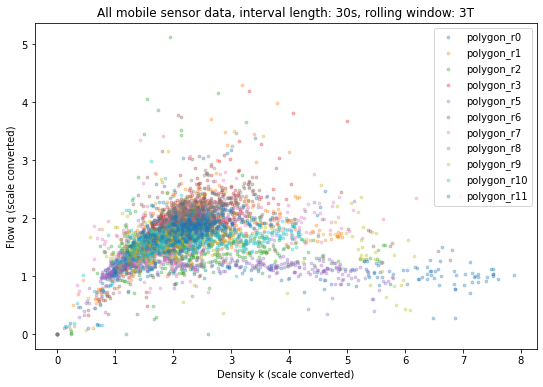

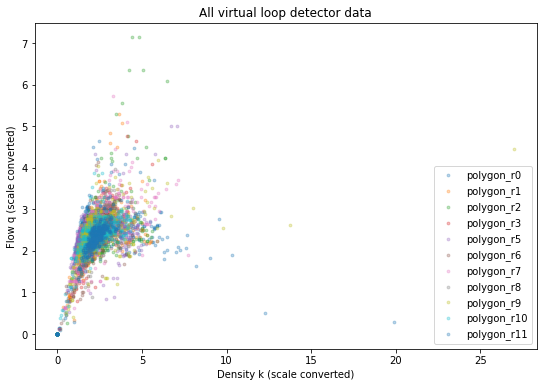

In [10]:
data = all_data 

# allMS data
plt.figure(figsize=(9,6))
for i in [0,1,2,3,5,6,7,8,9,10,11]:
    subset = data[data.polygon=='polygon_r%s'%i]
    plt.scatter(subset.k_all_MS,subset.q_all_MS,s=8,alpha=0.3,label=subset.polygon.values[0])
plt.title('All mobile sensor data, interval length: %s, rolling window: %s'%(resample,window))
plt.xlabel('Density k (scale converted)'); plt.ylabel('Flow q (scale converted)'); plt.legend()
#plt.savefig('All_MS_scaled.png')
plt.show()

# allLD data
plt.figure(figsize=(9,6))
for i in [0,1,2,3,5,6,7,8,9,10,11]:
    subset = data[data.polygon=='polygon_r%s'%i]
    plt.scatter(subset.k_all_LD,subset.q_all_LD,s=8,alpha=0.3,label=subset.polygon.values[0])
plt.title('All virtual loop detector data')
plt.xlabel('Density k (scale converted)');plt.ylabel('Flow q (scale converted)'); plt.legend()
#plt.savefig('All_LD_scaled.png')
plt.show()

#### Visualisation of the difference between v and vtarget

,polygon,vdiff,v_all,v2,q_all_LD,k_all_LD,q_all_LD_s,k_all_LD_s
0,polygon_r11,1.584690,10.414054,11.998744,0.292340,0.974767,414.780616,34.568670
1,polygon_r11,13.434926,25.913300,39.348226,2.046382,2.080699,2903.464312,73.788950
2,polygon_r11,11.295373,29.786912,41.082285,2.566098,2.499001,3640.852073,88.623407
3,polygon_r11,13.407224,26.592138,39.999362,1.973297,1.973727,2799.769158,69.995345
4,polygon_r11,12.855939,30.032306,42.888245,2.338722,2.181665,3318.244927,77.369566


Mean absolute speed difference: 7.21


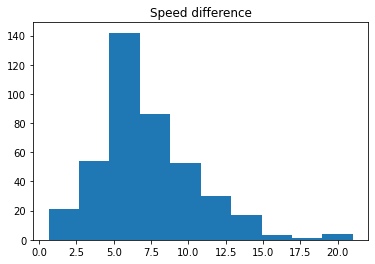

In [75]:
# test - scale values back up
cs = ['q_all_LD','k_all_LD']
result['q_all_LD'] = result.q_all
result['k_all_LD'] = result.k_all
for c in ['q_all_LD','k_all_LD']:
    scaledup = scaleup(result[c],result['polygon'],scalefactors,c)
    result['%s_s'%c] = scaledup
    cs.append('%s_s'%c)
result['v2'] = result.q_all_LD_s / result.k_all_LD_s

# difference between true 3min speed and derived 3min speed
result['vdiff'] = result.v2-result.v_all
display(result[['polygon','vdiff','v_all','v2']+cs].head())
print('Mean absolute speed difference: %.2f'%abs(result.vdiff).mean())
plt.hist(result.vdiff)
plt.title('Speed difference')
plt.show()

### Check for low speeds -> for bottlenecks !!!! old !!!!

In [12]:
#Filter for slow in genereal
#ideas: speed-diff between bus and all (heavy, medium)
all_slow = all_data[all_data['v_all_MS']<20]
super_slow = all_data[all_data['v_all_MS']<10]
print('all_slow',len(all_slow),'super_slow',len(super_slow),'all_data',len(all_data))

all_slow 15481 super_slow 10755 all_data 26845


In [ ]:
#1 do speed diff for heavy, medium, taxi
#2 do single botlenecks for each
#3 do either/or bottleneck
#4 do 2 or more bottleneck
#5 give ranking (e.g. speed diff - 30, 20, 10)

In [4]:
bottlenecks = all_data.copy()
bottlenecks['speed_diff_all_bus'] = bottlenecks.v_all_MS - bottlenecks.v_Bus_MS
bottlenecks['speed_diff_all_medium'] = bottlenecks.v_all_MS - bottlenecks['v_Medium Vehicle_MS']
bottlenecks['speed_diff_all_heavy'] = bottlenecks.v_all_MS - bottlenecks['v_Heavy Vehicle_MS']
bottlenecks['speed_diff_all_taxi'] = bottlenecks.v_all_MS - bottlenecks.v_Taxi_MS
bottlenecks['speed_diff_car_bus'] = bottlenecks.v_Car_MS - bottlenecks.v_Bus_MS
bottlenecks['speed_diff_car_medium'] = bottlenecks.v_Car_MS - bottlenecks['v_Medium Vehicle_MS']
bottlenecks['speed_diff_car_heavy'] = bottlenecks.v_Car_MS - bottlenecks['v_Heavy Vehicle_MS']
bottlenecks['speed_diff_car_taxi'] = bottlenecks.v_Car_MS - bottlenecks.v_Taxi_MS
bottlenecks['bus_stop'] = (bottlenecks['speed_diff_car_bus'] > 15) & (bottlenecks['v_Bus_MS'] < 5)
bottlenecks['heavy_stop'] = (bottlenecks['speed_diff_car_heavy'] > 15) & (bottlenecks['v_Heavy Vehicle_MS'] < 5)
bottlenecks['medium_stop'] = (bottlenecks['speed_diff_car_medium'] > 15) & (bottlenecks['v_Medium Vehicle_MS'] < 5)
bottlenecks['taxi_stop'] = (bottlenecks['speed_diff_car_taxi'] > 15) & (bottlenecks['v_Taxi_MS'] < 5)
bottlenecks['any_vehicle_stop'] = (bottlenecks['bus_stop'] | bottlenecks['medium_stop'] | bottlenecks['heavy_stop'] | bottlenecks['taxi_stop'])
bottlenecks['stop_counts'] = (bottlenecks['bus_stop']/1+bottlenecks['medium_stop']/1+bottlenecks['heavy_stop']/1+bottlenecks['taxi_stop']/1)

bottlenecks.head(10)

,exp_id,polygon,DOW,times,v_Car0050_MS,k_Car0050_MS,q_Car0050_MS,v_Medium Vehicle_MS,k_Medium Vehicle_MS,q_Medium Vehicle_MS,...,speed_diff_car_bus,speed_diff_car_medium,speed_diff_car_heavy,speed_diff_car_taxi,bus_stop,heavy_stop,medium_stop,taxi_stop,any_vehicle_stop,stop_counts
0,1.0,polygon_r0,Wed,2018-10-24 08:31:35,45.449044,0.057659,0.084569,NaN,0.000000,0.000000,...,4.695734,NaN,NaN,1.728552,False,False,False,False,False,0.0
6,1.0,polygon_r0,Wed,2018-10-24 08:32:05,NaN,0.000000,0.000000,NaN,0.000000,0.000000,...,NaN,NaN,NaN,NaN,False,False,False,False,False,0.0
12,1.0,polygon_r0,Wed,2018-10-24 08:32:35,NaN,0.000000,0.000000,NaN,0.000000,0.000000,...,NaN,NaN,NaN,NaN,False,False,False,False,False,0.0
18,1.0,polygon_r0,Wed,2018-10-24 08:33:05,50.542265,0.102758,0.167607,NaN,0.000000,0.000000,...,NaN,NaN,14.736732,-5.009644,False,False,False,False,False,0.0
24,1.0,polygon_r0,Wed,2018-10-24 08:33:35,NaN,0.000000,0.000000,38.632065,0.085632,0.106759,...,NaN,NaN,NaN,NaN,False,False,False,False,False,0.0
30,1.0,polygon_r0,Wed,2018-10-24 08:34:05,42.482957,0.077068,0.105661,NaN,0.000000,0.000000,...,NaN,NaN,NaN,14.984549,False,False,False,False,False,0.0
36,1.0,polygon_r0,Wed,2018-10-24 08:34:35,47.377892,0.118253,0.180805,40.414631,0.082777,0.107962,...,-3.472243,9.453359,NaN,0.607252,False,False,False,False,False,0.0
42,1.0,polygon_r0,Wed,2018-10-24 08:35:05,NaN,0.000000,0.000000,40.453986,0.091340,0.119247,...,NaN,5.566195,NaN,NaN,False,False,False,False,False,0.0
48,1.0,polygon_r0,Wed,2018-10-24 08:35:35,NaN,0.000000,0.000000,NaN,0.000000,0.000000,...,NaN,NaN,NaN,-7.508634,False,False,False,False,False,0.0
54,1.0,polygon_r0,Wed,2018-10-24 08:36:05,NaN,0.000000,0.000000,51.469437,0.108467,0.180164,...,NaN,-0.684316,NaN,NaN,False,False,False,False,False,0.0


<AxesSubplot:>

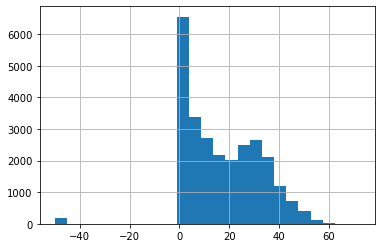

In [18]:
bottlenecks.v_all_MS.fillna(-50).hist(bins=25)

In [28]:
bottlenecks.stop_counts.value_counts()

0.0    25065
1.0     1496
2.0      262
3.0       21
4.0        1
Name: stop_counts, dtype: int64

In [22]:
stop_counts_pol = bottlenecks.groupby('polygon').stop_counts.value_counts()
stop_counts_pol

polygon      stop_counts
polygon_r0   0.0            2131
             1.0              28
             2.0               1
polygon_r1   0.0            2059
             1.0             385
             2.0              26
             3.0               1
polygon_r10  0.0            2469
             1.0              22
             2.0               1
polygon_r11  0.0            1728
             1.0             578
             2.0             192
             3.0              16
             4.0               1
polygon_r2   0.0            2471
             1.0              25
polygon_r3   0.0            2308
             1.0             191
             2.0              11
             3.0               3
polygon_r5   0.0            2289
             1.0              41
polygon_r6   0.0            2443
             1.0              58
             2.0               5
polygon_r7   0.0            2328
             1.0              62
             2.0               6
polygon_r8   0.0  

In [74]:
min_2 = bottlenecks[bottlenecks.stop_counts>=1]

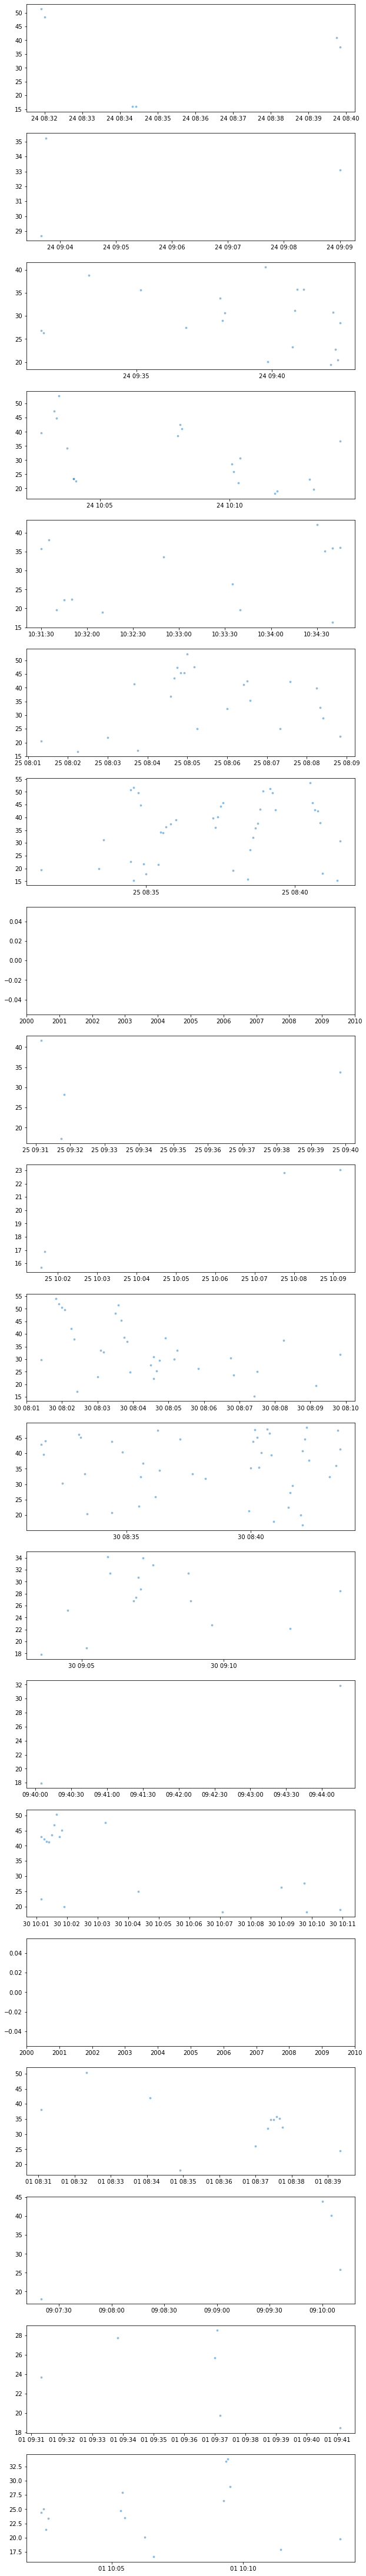

In [50]:
#plot speed data of cars in intervalls where min. one of bus/medium/heavy or taxi has speed-diff > 15 and v < 5
fig, axs = plt.subplots(20, figsize = (10,80))
for a in range(1,21):
    axs[a-1].scatter(min_2[min_2.exp_id==a].times, min_2[min_2.exp_id==a].v_Car_MS,s=8,alpha=0.4)
    axs[a-1].label=a

In [75]:
e4_min2 = min_2[min_2.exp_id==19]
e4_min2[['exp_id','polygon','times','v_Car_MS','q_Car_MS','v_Car0050_MS','speed_diff_car_bus',
         'speed_diff_car_medium', 'speed_diff_car_heavy', 'speed_diff_car_taxi','stop_counts']]

,exp_id,polygon,times,v_Car_MS,q_Car_MS,v_Car0050_MS,speed_diff_car_bus,speed_diff_car_medium,speed_diff_car_heavy,speed_diff_car_taxi,stop_counts
14400,19.0,polygon_r1,2018-11-01 09:37:00,17.174994,0.305485,45.741775,15.674186,NaN,NaN,1.915384,1.0
14406,19.0,polygon_r1,2018-11-01 09:37:30,28.434091,0.618974,35.748909,27.499781,NaN,NaN,2.114823,1.0
14460,19.0,polygon_r1,2018-11-01 09:42:00,21.645455,0.617724,28.836686,0.502607,21.645455,NaN,-6.873202,1.0
16713,19.0,polygon_r1,2018-11-01 09:31:20,23.685514,0.836284,NaN,18.717490,NaN,21.145972,4.498000,2.0
16769,19.0,polygon_r1,2018-11-01 09:36:55,20.118412,0.363180,NaN,15.538331,NaN,NaN,3.558814,1.0
...,...,...,...,...,...,...,...,...,...,...,...
89761,19.0,polygon_r11,2018-11-01 09:37:05,41.276189,0.585353,NaN,41.276189,-2.972082,NaN,12.655378,1.0
89762,19.0,polygon_r11,2018-11-01 09:37:10,23.856186,0.293983,NaN,23.856186,9.349863,NaN,2.294478,1.0
89791,19.0,polygon_r11,2018-11-01 09:40:05,33.921580,0.636982,NaN,33.661634,NaN,NaN,-5.654448,1.0
89792,19.0,polygon_r11,2018-11-01 09:40:10,25.409349,0.337973,NaN,25.409349,NaN,NaN,-8.537878,1.0


<AxesSubplot:>

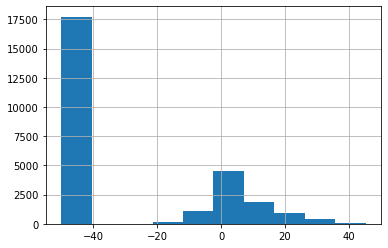

In [12]:
bottlenecks.speed_diff_car_bus.fillna(-50).hist()

In [7]:
only_with_bus = bottlenecks[~bottlenecks.speed_diff_car_bus.isnull()]

In [ ]:
only_with_bus.columns

<AxesSubplot:>

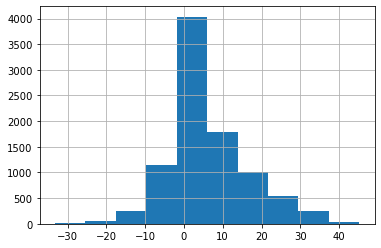

In [35]:
#current: Nan where no bus, difference between bus and car
#correlation should be: high car when high bus or low car and low bus (no influence), 
#lower car when diff positive high and bus 0 compared to no bus

#--> mean car for bus<10 and speed_diff > 20
#--> mean car for no bus

only_with_bus.speed_diff_car_bus.hist()

In [ ]:
only_with_bus.boxplot(by='speed_diff_car_bus')#.hist(bins=25)


KeyboardInterrupt



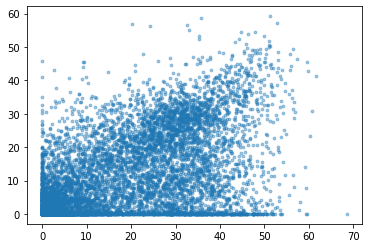

In [34]:
plt.scatter(only_with_bus.v_Car_MS,only_with_bus.v_Bus_MS,s=8,alpha=0.4)
#only_with_bus[only_with_bus.speed_diff_car_bus]

<AxesSubplot:>

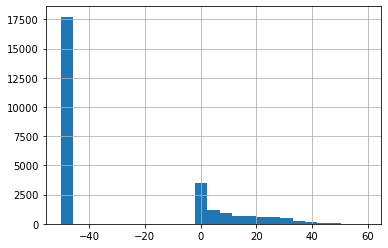

In [43]:
all_data.v_Bus_MS.fillna(-50).hist(bins=25)

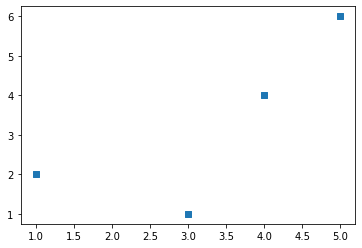

In [15]:
plt.scatter([1,3,5,4],[2,1,6,4],marker=",")

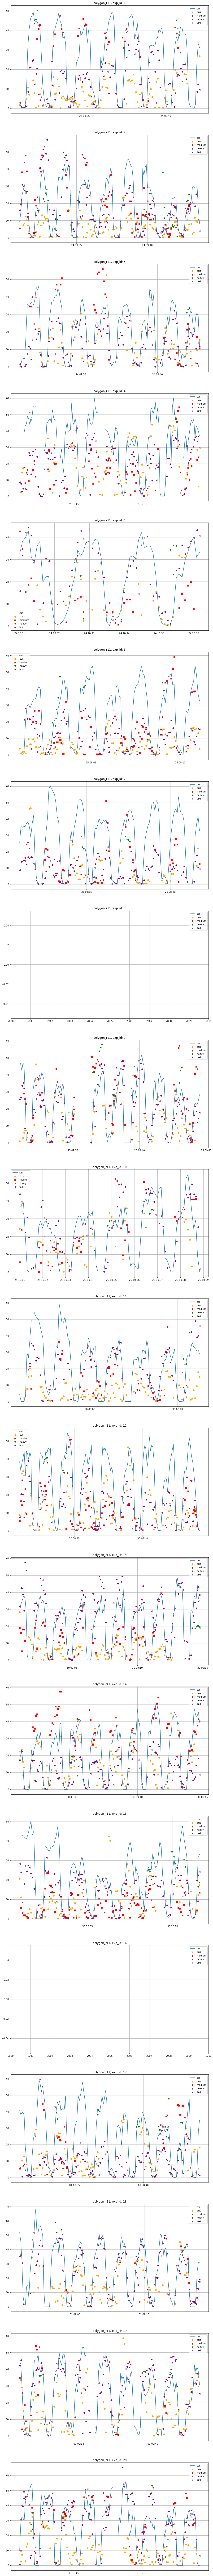

In [21]:
polygon = 11
polygon_str = 'polygon_r%s'%(polygon)
r_pol = all_data[(all_data.polygon==polygon_str)]

r_pol['v_Bus_MS'] = np.where((r_pol.q_Bus_MS < 0.001),None,r_pol.v_Bus_MS)
r_pol['v_Medium Vehicle_MS'] = np.where((r_pol['q_Medium Vehicle_MS'] < 0.001),None,r_pol['v_Medium Vehicle_MS'])
r_pol['v_Heavy Vehicle_MS'] = np.where((r_pol['q_Heavy Vehicle_MS'] < 0.001),None,r_pol['v_Heavy Vehicle_MS'])
r_pol['v_Taxi_MS'] = np.where((r_pol['q_Taxi_MS'] < 0.001),None,r_pol['v_Taxi_MS'])
#"." , "," , "o" , "v" , "^" , "<", ">"]
fig, axs = plt.subplots(20, figsize = (15,200))
for a in range(1,21):
    pol_exp_id = r_pol[r_pol.exp_id==a].sort_values('times')
    axs[a-1].plot(pol_exp_id.times, pol_exp_id.v_Car_MS)#,s=8,alpha=0.8)
    axs[a-1].scatter(pol_exp_id.times, pol_exp_id.v_Bus_MS,c='orange',marker="o")#s=8,alpha=0.8)
    axs[a-1].scatter(pol_exp_id.times, pol_exp_id['v_Medium Vehicle_MS'],marker = ",",c='red')#, s=8,alpha=0.8)
    axs[a-1].scatter(pol_exp_id.times, pol_exp_id['v_Heavy Vehicle_MS'],marker = "v",c='green')#,s=8,alpha=0.8)
    axs[a-1].scatter(pol_exp_id.times, pol_exp_id['v_Taxi_MS'],marker = "<",c='purple')#,s=8,alpha=0.8)
    axs[a-1].title.set_text(polygon_str+', exp_id: '+str(a))
    axs[a-1].legend(['car','bus','medium','heavy','taxi'])
    axs[a-1].grid()

In [15]:
only_with_bus[['exp_id','v_all_MS','v_Bus_MS','v_Car_MS','speed_diff_car_bus','q_Car0050_MS','lanes', 'direction', 'busstops',
       'seplane', 'length', 'complexity']].corr('pearson')

,exp_id,v_all_MS,v_Bus_MS,v_Car_MS,speed_diff_car_bus,q_Car0050_MS,lanes,direction,busstops,seplane,length,complexity
exp_id,1.000000,0.087055,0.057387,0.082788,0.047071,0.022832,0.018333,0.010269,0.077194,-0.054983,0.035468,NaN
v_all_MS,0.087055,1.000000,0.684634,0.930807,0.510710,0.071677,0.327045,0.027615,0.008571,0.144894,0.069364,NaN
v_Bus_MS,0.057387,0.684634,1.000000,0.555598,-0.277014,0.043778,0.091144,0.123033,-0.239094,0.356459,-0.081848,NaN
v_Car_MS,0.082788,0.930807,0.555598,1.000000,0.563920,0.062741,0.384232,-0.028918,0.100312,0.042225,0.136049,NaN
speed_diff_car_bus,0.047071,0.510710,-0.277014,0.563920,1.000000,0.042851,0.323624,-0.108719,0.293321,-0.229449,0.187983,NaN
q_Car0050_MS,0.022832,0.071677,0.043778,0.062741,0.042851,1.000000,0.007488,-0.010892,0.004853,-0.015841,-0.007302,NaN
lanes,0.018333,0.327045,0.091144,0.384232,0.323624,0.007488,1.000000,-0.385975,0.190217,0.002271,0.584298,NaN
direction,0.010269,0.027615,0.123033,-0.028918,-0.108719,-0.010892,-0.385975,1.000000,0.193777,0.109805,-0.195322,NaN
busstops,0.077194,0.008571,-0.239094,0.100312,0.293321,0.004853,0.190217,0.193777,1.000000,-0.707518,0.117370,NaN
seplane,-0.054983,0.144894,0.356459,0.042225,-0.229449,-0.015841,0.002271,0.109805,-0.707518,1.000000,0.018844,NaN


In [28]:
pol0_all = all_data[all_data['polygon'] == 'polygon_r0']
len(pol0_all)

417

In [42]:
for row,index in pol0_all.iterrows():
    print(row, index['times'], index.v_all_MS)

0 2018-10-24 08:30:00 40.790122970952055
1 2018-10-24 08:33:00 42.80521216764917
2 2018-10-24 08:36:00 44.15276177141456
3 2018-10-24 08:39:00 47.93096732490546
10 2018-10-24 09:00:00 33.63439159420024
11 2018-10-24 09:03:00 7.6813235987032344
12 2018-10-24 09:06:00 9.716112636127058
13 2018-10-24 09:09:00 7.475230841988899
14 2018-10-24 09:12:00 7.255886096150206
20 2018-10-24 09:30:00 6.009259904518497
21 2018-10-24 09:33:00 6.1147065195841686
22 2018-10-24 09:36:00 8.163732840105569
23 2018-10-24 09:39:00 5.281993229116394
24 2018-10-24 09:42:00 5.804997263690013
30 2018-10-24 10:00:00 4.659420785084534
31 2018-10-24 10:03:00 5.983137734383291
32 2018-10-24 10:06:00 6.59463631783115
33 2018-10-24 10:09:00 7.393292003741533
34 2018-10-24 10:12:00 7.164103465518976
40 2018-10-24 10:30:00 8.294393857891855
41 2018-10-24 10:33:00 6.03004425186396
42 2018-10-24 10:36:00 1.0660330301681655
43 2018-10-25 08:00:00 47.59109039577289
44 2018-10-25 08:03:00 44.599719384997236
45 2018-10-25 08:

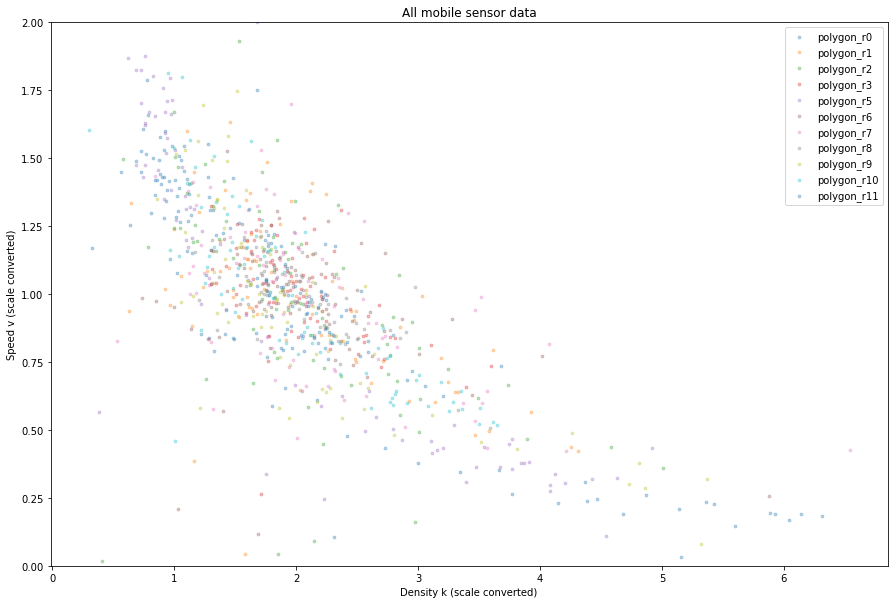

In [23]:
# allMS data - speed-density plot - scaled by mean-speed and density
plt.figure(figsize=(15,10))
speed_scales = all_data.groupby(['polygon'])['v_all_MS'].mean()
for i in [0,1,2,3,5,6,7,8,9,10,11]:
    subset = data[data.polygon=='polygon_r%s'%i]
    speed_scale = speed_scales['polygon_r%s'%i]
    plt.scatter(subset.k_all_MS,subset.v_all_MS/speed_scale,s=8,alpha=0.3,label=subset.polygon.values[0])
plt.title('All mobile sensor data')
plt.xlabel('Density k (scale converted)'); plt.ylabel('Speed v (scale converted)'); plt.legend()
plt.ylim(0,2)
#plt.savefig('All_MS_scaled.png')
plt.show()

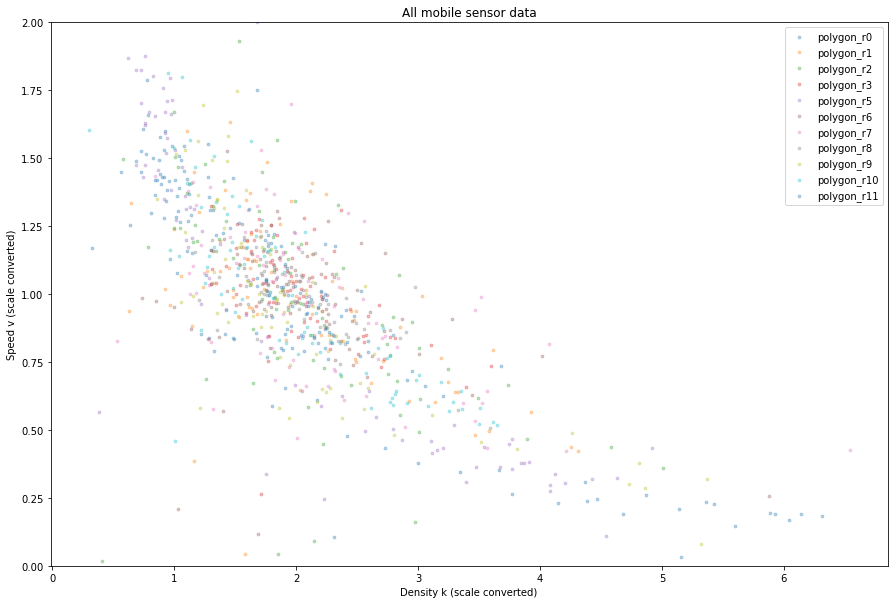

In [24]:
# allMS data - speed-density plot - scaled by mean-speed and density
plt.figure(figsize=(15,10))
speed_scales = all_data.groupby(['polygon'])['v_all_MS'].mean()
for i in [0,1,2,3,5,6,7,8,9,10,11]:
    subset = data[data.polygon=='polygon_r%s'%i]
    speed_scale = speed_scales['polygon_r%s'%i]
    plt.scatter(subset.k_all_MS,subset.v_all_MS/speed_scale,s=8,alpha=0.3,label=subset.polygon.values[0])
plt.title('All mobile sensor data')
plt.xlabel('Density k (scale converted)'); plt.ylabel('Speed v (scale converted)'); plt.legend()
plt.ylim(0,2)
#plt.savefig('All_MS_scaled.png')
plt.show()

In [25]:
to_check = super_slow.value_counts(['polygon','exp_id'])
to_check

polygon      exp_id
polygon_r10  18.0      5
polygon_r9   3.0       5
polygon_r0   3.0       5
polygon_r2   20.0      5
polygon_r7   4.0       5
                      ..
polygon_r2   13.0      1
             11.0      1
polygon_r7   7.0       1
             11.0      1
polygon_r3   1.0       1
Length: 86, dtype: int64

In [26]:
to_check.loc[['polygon_r0','polygon_r5','polygon_r9'],:]

polygon     exp_id
polygon_r0  3.0       5
            4.0       5
            2.0       4
            5.0       3
            15.0      1
polygon_r5  3.0       5
            2.0       5
            4.0       4
            15.0      4
            5.0       3
            10.0      2
            20.0      2
polygon_r9  3.0       5
            2.0       5
            17.0      5
            14.0      4
            1.0       4
            13.0      4
            18.0      3
            9.0       3
            10.0      3
            15.0      3
            4.0       3
            20.0      3
            5.0       2
            12.0      2
            19.0      1
            11.0      1
            6.0       1
dtype: int64

In [11]:
#super_slow_exp2_r0 = super_slow[(super_slow.exp_id == 1.0) & (super_slow.polygon == 'polygon_r0')]
exp2_r = all_data[(all_data.exp_id == 6.0) & (all_data.polygon == 'polygon_r9')]
exp2_r[['times','v_all_MS']]

,times,v_all_MS
11876,2018-10-25 08:01:00,18.906831
11877,2018-10-25 08:01:30,13.558602
11878,2018-10-25 08:02:00,9.602749
11879,2018-10-25 08:02:30,13.006471
11880,2018-10-25 08:03:00,12.987725
11881,2018-10-25 08:03:30,11.134856
11882,2018-10-25 08:04:00,11.015376
11883,2018-10-25 08:04:30,11.242612
11884,2018-10-25 08:05:00,11.176129
11885,2018-10-25 08:05:30,10.085056


In [77]:
all_data.columns

Index(['exp_id', 'polygon', 'DOW', 'times', 'v_Taxi_MS', 'k_Taxi_MS',
       'q_Taxi_MS', 'v_Car0050_MS', 'k_Car0050_MS', 'q_Car0050_MS', 'v_Car_MS',
       'k_Car_MS', 'q_Car_MS', 'v_Heavy Vehicle_MS', 'k_Heavy Vehicle_MS',
       'q_Heavy Vehicle_MS', 'v_all_MS', 'k_all_MS', 'q_all_MS',
       'v_Medium Vehicle_MS', 'k_Medium Vehicle_MS', 'q_Medium Vehicle_MS',
       'v_Bus_MS', 'k_Bus_MS', 'q_Bus_MS', 'v_Motorcycle_MS',
       'k_Motorcycle_MS', 'q_Motorcycle_MS', 'lanes', 'direction', 'busstops',
       'seplane', 'length', 'complexity', 'road_rank', 'v_all_LD', 'k_all_LD',
       'q_all_LD'],
      dtype='object')

In [13]:
extended_data = all_data.copy()

In [14]:
extended_data['diff_car_bus'] = extended_data['v_Car_MS'] - extended_data['v_Bus_MS']
extended_data['diff_car_heavy'] = extended_data['v_Car_MS'] - extended_data['v_Heavy Vehicle_MS']
extended_data['diff_car_taxi'] = extended_data['v_Car_MS'] - extended_data['v_Taxi_MS']

<AxesSubplot:>

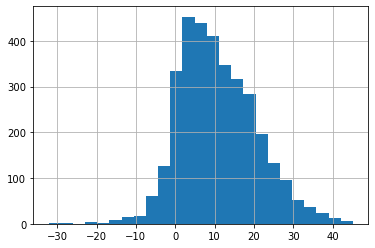

In [21]:
extended_data['diff_car_bus'].hist(bins=25)

<AxesSubplot:>

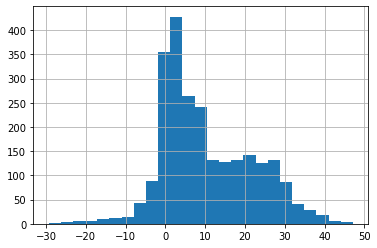

In [22]:
extended_data['diff_car_heavy'].hist(bins=25)

<AxesSubplot:>

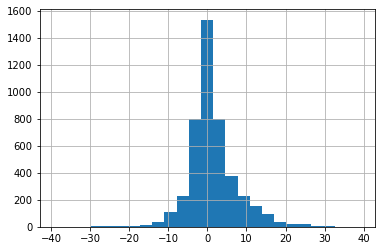

In [23]:
extended_data['diff_car_taxi'].hist(bins=25)

<AxesSubplot:>

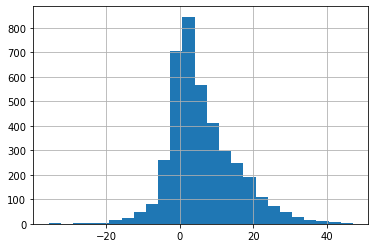

In [24]:
extended_data['diff_car_medium'] = extended_data['v_Car_MS'] - extended_data['v_Medium Vehicle_MS']
extended_data['diff_car_medium'].hist(bins=25)

<AxesSubplot:>

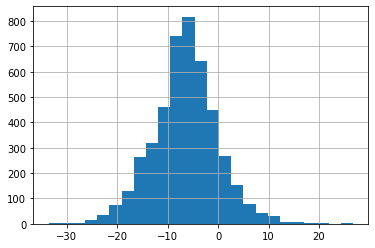

In [25]:
extended_data['diff_car_motorcycle'] = extended_data['v_Car_MS'] - extended_data['v_Motorcycle_MS']
extended_data['diff_car_motorcycle'].hist(bins=25)

<AxesSubplot:>

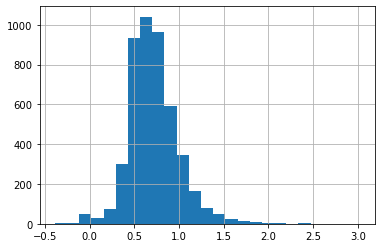

In [26]:
extended_data['diff_qcar_bus'] = extended_data['q_Car_MS'] - extended_data['q_Bus_MS']
extended_data['diff_qcar_heavy'] = extended_data['q_Car_MS'] - extended_data['q_Heavy Vehicle_MS']
extended_data['diff_qcar_mocy'] = extended_data['q_Car_MS'] - extended_data['q_Motorcycle_MS']
extended_data['diff_qcar_bus'].hist(bins=25)

<AxesSubplot:>

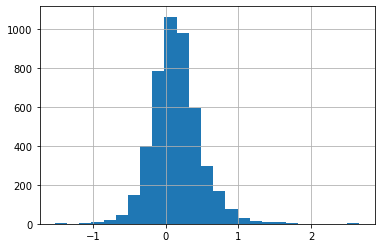

In [29]:
#extended_data['diff_qcar_heavy'].hist(bins=25)
extended_data['diff_qcar_mocy'].hist(bins=25)

In [66]:
all_data.times.info

<bound method Series.info of 0       2018-10-24 08:31:00
1       2018-10-24 08:31:30
2       2018-10-24 08:32:00
3       2018-10-24 08:32:30
4       2018-10-24 08:33:00
                ...        
14381   2018-10-30 09:45:00
14382   2018-10-30 09:45:30
14383   2018-10-30 09:46:00
14384   2018-10-30 09:46:30
14385   2018-10-30 09:47:00
Name: times, Length: 4668, dtype: datetime64[ns]>

In [85]:
import datetime
times = []
values = []
for ti in range(0,30):
    times.append(datetime.datetime(2022,6,13,10,14,ti))
    values.append(ti**2) 

In [86]:
rand_df = pd.DataFrame(list(zip(times,values)), columns = ['Zeitstempel','Werte'])
rand_df.index = pd.Series(times)

In [87]:
rand_df_res = rand_df.resample('8s').mean()

In [88]:
rand_df_res

,Werte
2022-06-13 10:14:00,17.500000
2022-06-13 10:14:08,137.500000
2022-06-13 10:14:16,385.500000
2022-06-13 10:14:24,705.166667
